# Macroeconometrics Project

Replication and extension study for the discussion paper 'An empirical assessment of the U.S. Phillips curve over time' by Marente Vlekke, Siem Jan Koopman and Martin Mellens.

In [133]:
import arviz as az
import jax
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import plotnine as p9
import statsmodels.api as sm

from pandas_datareader import fred
from scipy import stats, optimize
from statsmodels.base.model import GenericLikelihoodModel

In [134]:
jax.config.update('jax_platform_name', 'cpu')
numpyro.set_host_device_count(8)

In [135]:
seed = sum(map(ord, 'Macroeconometrics project, Vlekke, Kooman and Mellens replication'))
rng = np.random.default_rng(seed)

## Data

In [136]:
import datetime
import requests_cache

session = requests_cache.CachedSession(cache_name='fred', backend='sqlite', expire_after=datetime.timedelta(days=1))

fred_symbols = [
    # Inflation
    'CPIAUCSL', # Consumer Price Index for All Urban Consumers: All Items in U.S. City Average, Index 1982-1984=100, Seasonally Adjusted, Monthly
    'CPILFESL', #  Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average, Index 1982-1984=100, Seasonally Adjusted, Monthly
    'PCEPI', # Personal Consumption Expenditures: Chain-type Price Index, Index 2017=100, Seasonally Adjusted, Monthly
    'PCEPILFE', # Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index), Index 2017=100, Seasonally Adjusted, Monthly
    # Unemployment
    'UNRATE', # Unemployment Rate, Percent, Seasonally Adjusted, Monthly
    'NROU', # Noncyclical Rate of Unemployment, Percent, Not Seasonally Adjusted, Quarterly
    # GDP
    'GDP', # Gross Domestic Product, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
    'NGDPPOT', # Nominal Potential Gross Domestic Product, Billions of Dollars, Not Seasonally Adjusted, Quarterly
    'GDPPOT', # Real Potential Gross Domestic Product, Billions of Chained 2017 Dollars, Not Seasonally Adjusted, Quarterly
    # Supply shock control variables
    'A021RD3Q086SBEA', # Imports of goods and services (implicit price deflator), Index 2017=100, Seasonally Adjusted, Quarterly
    'GDPDEF', # Gross Domestic Product: Implicit Price Deflator, Index 2017=100, Seasonally Adjusted, Quarterly
    'WTISPLC', # Spot Crude Oil Price: West Texas Intermediate (WTI), Dollars per Barrel, Not Seasonally Adjusted, Monthly
    # Interest rate
    'FEDFUNDS', # Federal Funds Effective Rate, Percent, Not Seasonally Adjusted, Monthly
    # Inflation expectations
    'MICH', # University of Michigan: Inflation Expectation, Percent, Not Seasonally Adjusted, Monthly
]

fred_raw = fred.FredReader(symbols=fred_symbols, start=1900, end=2025, session=session).read()

In [137]:
# Resample data as quarterly data, take the last observation during that period
fred_df = fred_raw.resample('QS').last()

# Limit data to before 2025
fred_df = fred_df[fred_df.index < '2025-01-01']

# Calculate annualized quarter-on-quarter inflation changes
fred_df['cpi_a'] = fred_df['CPIAUCSL'].pct_change(periods=4) * 100
fred_df['cpix_a'] = fred_df['CPILFESL'].pct_change(periods=4) * 100
fred_df['pce_a'] = fred_df['PCEPI'].pct_change(periods=4) * 100
fred_df['pcex_a'] = fred_df['PCEPILFE'].pct_change(periods=4) * 100
fred_df['cpi_aqoq'] = ((1 + fred_df['CPIAUCSL'].pct_change()) ** 4 - 1) * 100
fred_df['cpix_aqoq'] = ((1 + fred_df['CPILFESL'].pct_change()) ** 4 - 1) * 100
fred_df['pce_aqoq'] = ((1 + fred_df['PCEPI'].pct_change()) ** 4 - 1) * 100
fred_df['pcex_aqoq'] = ((1 + fred_df['PCEPILFE'].pct_change()) ** 4 - 1) * 100

# Unemployment
fred_df['u'] = fred_df['UNRATE']
fred_df['u_n'] = fred_df['NROU']
fred_df['u_gap'] = fred_df['u'] - fred_df['u_n']

# Supply shock control variables
fred_df['imp'] = fred_df['A021RD3Q086SBEA']
fred_df['gdp_def'] = fred_df['GDPDEF']
fred_df['rel_imp_p_idx'] = fred_df['imp'] / fred_df['gdp_def']
fred_df['rel_imp_p_aqoq'] = ((1 + fred_df['rel_imp_p_idx'].pct_change(fill_method=None)) ** 4 - 1) * 100
fred_df['oil_p_aqoq'] = ((1 + fred_df['WTISPLC'].pct_change()) ** 4 - 1) * 100

# Interest rates
fred_df['i'] = fred_df['FEDFUNDS']

# Cosnumer inflation expectations
fred_df['e_h_cpi_1'] = fred_df['MICH']

# Backwards-looking expectations
fred_df['e_b_cpi'] = fred_df['cpi_aqoq'].rolling(window=4).mean().shift(1)
fred_df['e_b_cpix'] = fred_df['cpix_aqoq'].rolling(window=4).mean().shift(1)
fred_df['e_b_pce'] = fred_df['pce_aqoq'].rolling(window=4).mean().shift(1)
fred_df['e_b_pcex'] = fred_df['pcex_aqoq'].rolling(window=4).mean().shift(1)

fred_df = fred_df[['cpi_a', 'cpix_a', 'pce_a', 'pcex_a',
                   'cpi_aqoq', 'cpix_aqoq', 'pce_aqoq', 'pcex_aqoq',
                   'u', 'u_n', 'u_gap',
                   'imp', 'gdp_def', 'rel_imp_p_idx', 'rel_imp_p_aqoq', 'oil_p_aqoq',
                   'i',
                   'e_h_cpi_1', 'e_b_cpi', 'e_b_cpix', 'e_b_pce', 'e_b_pcex']]

In [138]:
fred_df.tail()

cpi_a    cpix_a     pce_a    pcex_a  cpi_aqoq  cpix_aqoq  \
DATE                                                                      
2023-10-01  3.323160  3.910120  2.701790  3.035639  1.906163   3.343949   
2024-01-01  3.475131  3.797294  2.809633  2.979612  4.596141   4.530819   
2024-04-01  2.975629  3.276939  2.436169  2.630477  1.053362   2.097782   
2024-07-01  2.407513  3.258714  2.102367  2.660780  2.108149   3.076850   
2024-10-01  2.493668  3.016516  2.286147  2.630924  2.249526   2.377763   

            pce_aqoq  pcex_aqoq    u       u_n  ...  gdp_def  rel_imp_p_idx  \
DATE                                            ...                           
2023-10-01  0.710362   1.636068  3.8  4.419751  ...  123.241       0.901145   
2024-01-01  4.379274   4.388082  3.9  4.416962  ...  124.163       0.900317   
2024-04-01  1.495558   2.254738  4.1  4.414191  ...  124.943       0.899386   
2024-07-01  1.860962   2.384926  4.1  4.411415  ...  125.532       0.894704   
2024-10-01  1.437419   1.517888  4.1  4.408619  ...      NaN            NaN   

            rel_imp_p_aqoq  oil_p_aqoq     i  e_h_cpi_1   e_b_cpi  e_b_cpix  \
DATE                                                                          
2023-10-01       -1.537027  -58.218634  5.33        3.1  3.695399  4.145765   
2024-01-01       -0.367200   63.312421  5.33        2.9  3.327616  3.912671   
2024-04-01       -0.412725   -7.226575  5.33        3.0  3.480896  3.798862   
2024-07-01       -2.066097  -39.885444  5.13        2.7  2.987139  3.280547   
2024-10-01             NaN   -0.681622  4.48        2.6  2.415954  3.262350   

             e_b_pce  e_b_pcex  
DATE                            
2023-10-01  3.416978  3.660718  
2024-01-01  2.708934  3.042222  
2024-04-01  2.818251  2.985381  
2024-07-01  2.446188  2.635745  
2024-10-01  2.111539  2.665953  

[5 rows x 22 columns]

In [139]:
spf_files = [
    'Median_CPI_Level.xlsx',
    'Median_CPI5YR_Level.xlsx',
    'Median_CPI10_Level.xlsx',
    'Median_CORECPI_Level.xlsx',
    'Median_COREPCE_Level.xlsx',
    'Median_PCE_Level.xlsx',
    'Median_PCE5YR_Level.xlsx',
    'Median_PCE10_Level.xlsx',
]

spf_raw = pd.concat([pd.read_excel(f'data/{spf_file}').set_index(['YEAR', 'QUARTER']) for spf_file in spf_files], axis=1)
spf_raw.columns

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it wi

Index(['CPI1', 'CPI2', 'CPI3', 'CPI4', 'CPI5', 'CPI6', 'CPIA', 'CPIB', 'CPIC',
       'CPI5YR', 'CPI10', 'CORECPI1', 'CORECPI2', 'CORECPI3', 'CORECPI4',
       'CORECPI5', 'CORECPI6', 'CORECPIA', 'CORECPIB', 'CORECPIC', 'COREPCE1',
       'COREPCE2', 'COREPCE3', 'COREPCE4', 'COREPCE5', 'COREPCE6', 'COREPCEA',
       'COREPCEB', 'COREPCEC', 'PCE1', 'PCE2', 'PCE3', 'PCE4', 'PCE5', 'PCE6',
       'PCEA', 'PCEB', 'PCEC', 'PCE5YR', 'PCE10'],
      dtype='object')

In [140]:
spf_df = spf_raw[['CPIA', 'CPI10', 'CORECPIA', 'PCEA', 'PCE10', 'COREPCEA']]
spf_df = spf_df.rename(columns={
    'CPIA': 'e_p_cpi_1',
    'CPI10': 'e_p_cpi_10',
    'CORECPIA': 'e_p_cpix_1',
    'PCEA': 'e_p_pce_1',
    'PCE10': 'e_p_pce_10',
    'COREPCEA': 'e_p_pcex_1',
})
spf_df = spf_df.reset_index()
spf_df['DATE'] = spf_df['YEAR'].astype(str) + '-Q' + spf_df['QUARTER'].astype(str)
spf_df['DATE'] = pd.PeriodIndex(spf_df['DATE'], freq='Q').to_timestamp()
spf_df = spf_df.drop(columns=['YEAR', 'QUARTER']).set_index('DATE')

In [141]:
spf_df.tail()

e_p_cpi_1  e_p_cpi_10  e_p_cpix_1  e_p_pce_1  e_p_pce_10  \
DATE                                                                   
2023-10-01     3.3373       2.400      3.8922     3.1115        2.22   
2024-01-01     2.4905       2.240      2.6873     2.0948        2.00   
2024-04-01     3.1235       2.325      3.4000     2.7742        2.10   
2024-07-01     2.8471       2.300      3.1534     2.5511        2.10   
2024-10-01     2.5127       2.225      3.1000     2.3651        2.10   

            e_p_pcex_1  
DATE                    
2023-10-01      3.4625  
2024-01-01      2.1170  
2024-04-01      2.9094  
2024-07-01      2.8053  
2024-10-01      2.7375

In [142]:
df = fred_df.join(spf_df, how='outer')
df.index.freq = pd.tseries.frequencies.to_offset('QS')

# Inflation and expected inflation minus backwards-looking inflation expectations
df['cpi_aqoq_meb'] = df['cpi_aqoq'] - df['e_b_cpi']
df['cpix_meb'] = df['cpix_aqoq'] - df['e_b_cpix']
df['pce_meb'] = df['pce_aqoq'] - df['e_b_pce']
df['pcex_meb'] = df['pcex_aqoq'] - df['e_b_pcex']

df['e_p_cpi_1_meb'] = df['e_p_cpi_1'] - df['e_b_cpi']
df['e_p_cpi_10_meb'] = df['e_p_cpi_10'] - df['e_b_cpi']
df['e_p_cpix_1_meb'] = df['e_p_cpix_1'] - df['e_b_cpix']
df['e_p_pce_1_meb'] = df['e_p_pce_1'] - df['e_b_pce']
df['e_p_pce_10_meb'] = df['e_p_pce_10'] - df['e_b_pce']
df['e_p_pcex_1_meb'] = df['e_p_pcex_1'] - df['e_b_pcex']

df['e_h_cpi_1_meb'] = df['e_h_cpi_1'] - df['e_b_cpi']

df.tail()

cpi_a    cpix_a     pce_a    pcex_a  cpi_aqoq  cpix_aqoq  \
DATE                                                                      
2023-10-01  3.323160  3.910120  2.701790  3.035639  1.906163   3.343949   
2024-01-01  3.475131  3.797294  2.809633  2.979612  4.596141   4.530819   
2024-04-01  2.975629  3.276939  2.436169  2.630477  1.053362   2.097782   
2024-07-01  2.407513  3.258714  2.102367  2.660780  2.108149   3.076850   
2024-10-01  2.493668  3.016516  2.286147  2.630924  2.249526   2.377763   

            pce_aqoq  pcex_aqoq    u       u_n  ...  cpix_meb   pce_meb  \
DATE                                            ...                       
2023-10-01  0.710362   1.636068  3.8  4.419751  ... -0.801816 -2.706616   
2024-01-01  4.379274   4.388082  3.9  4.416962  ...  0.618148  1.670339   
2024-04-01  1.495558   2.254738  4.1  4.414191  ... -1.701081 -1.322693   
2024-07-01  1.860962   2.384926  4.1  4.411415  ... -0.203697 -0.585227   
2024-10-01  1.437419   1.517888  4.1  4.408619  ... -0.884587 -0.674120   

            pcex_meb  e_p_cpi_1_meb  e_p_cpi_10_meb  e_p_cpix_1_meb  \
DATE                                                                  
2023-10-01 -2.024651      -0.358099       -1.295399       -0.253565   
2024-01-01  1.345860      -0.837116       -1.087616       -1.225371   
2024-04-01 -0.730643      -0.357396       -1.155896       -0.398862   
2024-07-01 -0.250819      -0.140039       -0.687139       -0.127147   
2024-10-01 -1.148066       0.096746       -0.190954       -0.162350   

            e_p_pce_1_meb  e_p_pce_10_meb  e_p_pcex_1_meb  e_h_cpi_1_meb  
DATE                                                                      
2023-10-01      -0.305478       -1.196978       -0.198218      -0.595399  
2024-01-01      -0.614134       -0.708934       -0.925222      -0.427616  
2024-04-01      -0.044051       -0.718251       -0.075981      -0.480896  
2024-07-01       0.104912       -0.346188        0.169555      -0.287139  
2024-10-01       0.253561       -0.011539        0.071547       0.184046  

[5 rows x 39 columns]

### Inflation

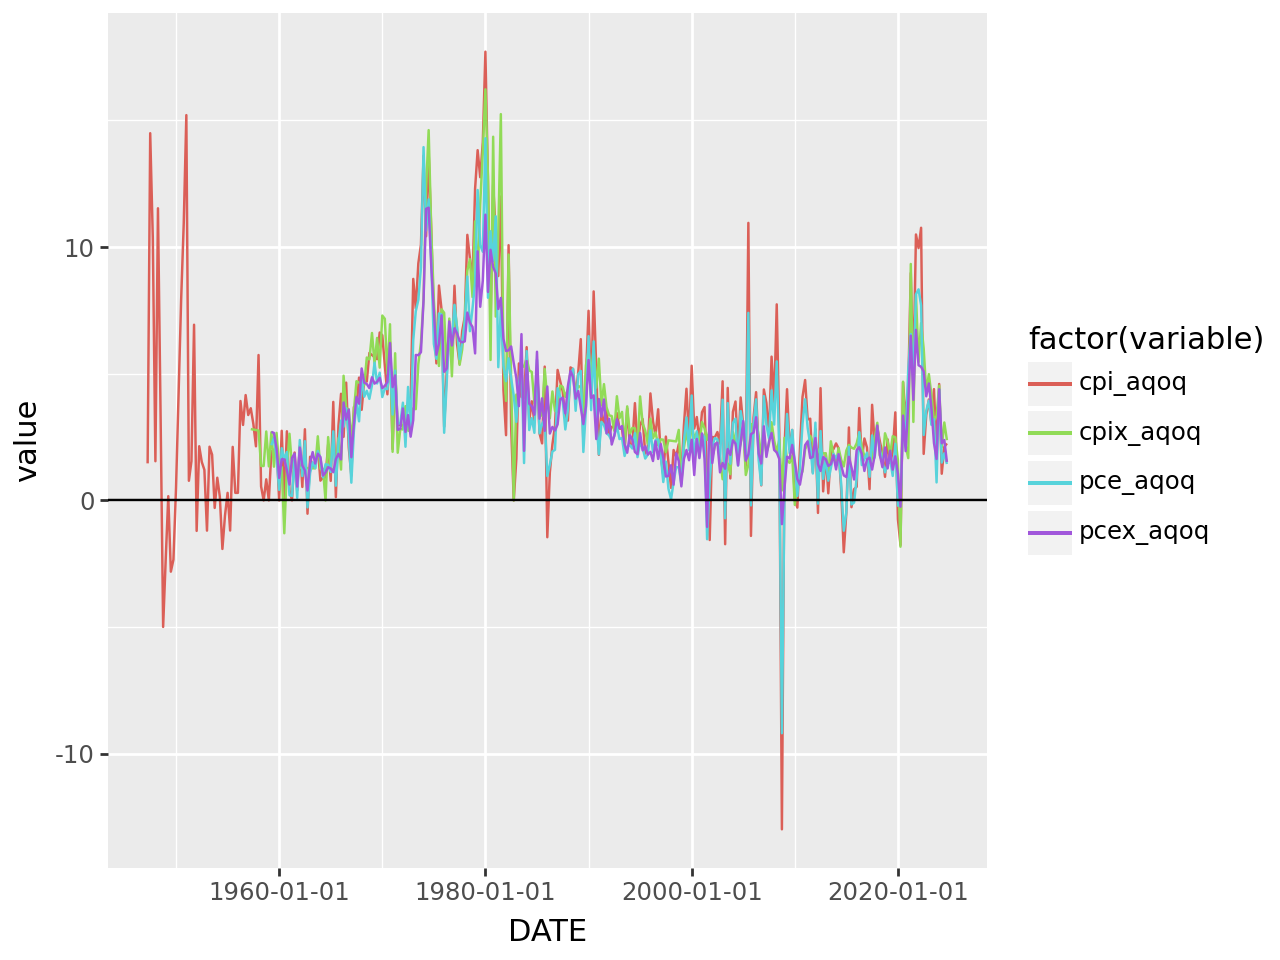

In [143]:
cpi_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['cpi_aqoq', 'cpix_aqoq', 'pce_aqoq', 'pcex_aqoq']).dropna()

(
    p9.ggplot(cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Inflation expectations

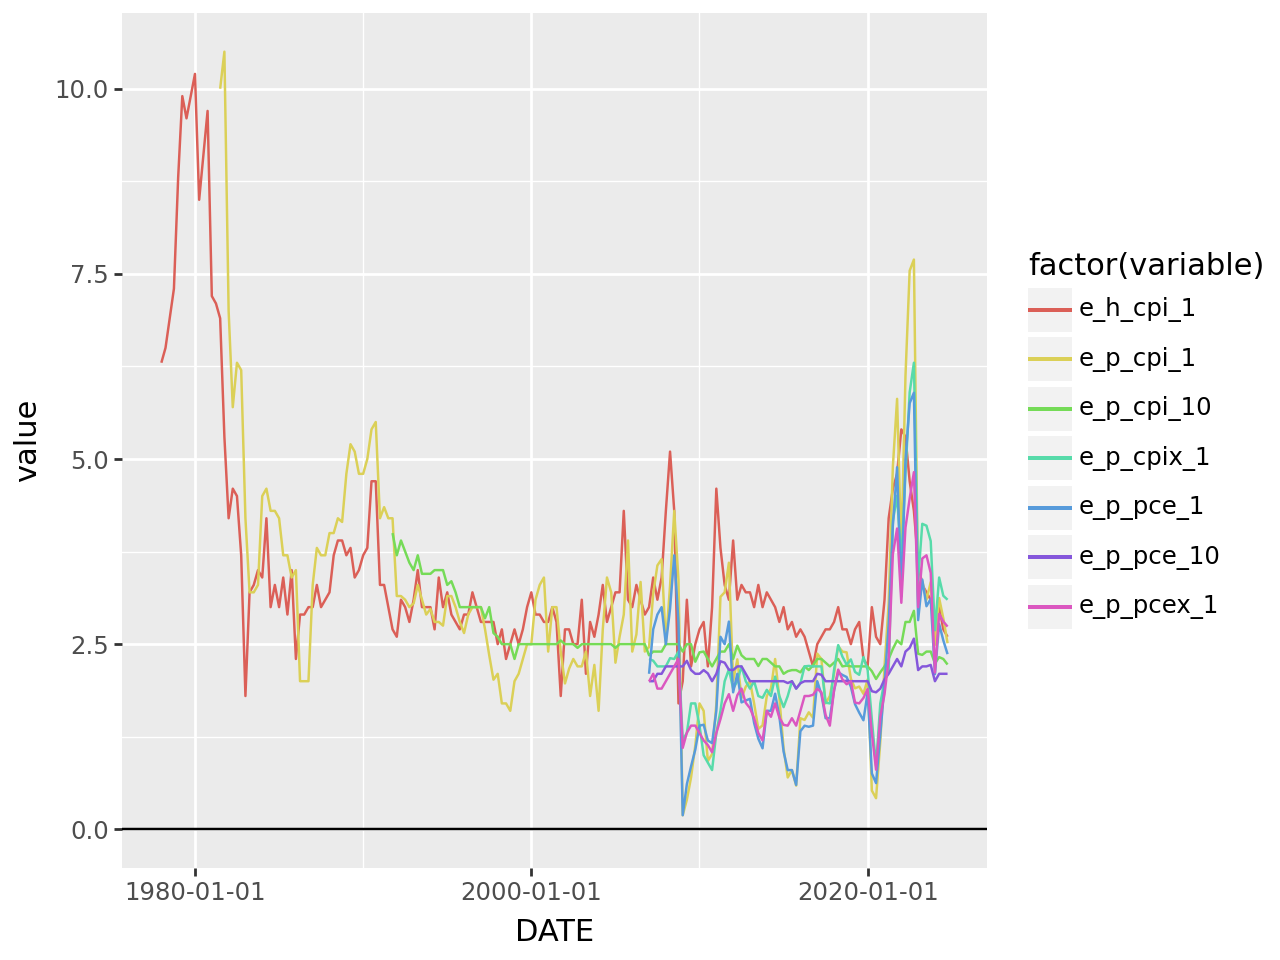

In [144]:
e_cpi_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['e_h_cpi_1', 'e_p_cpi_1', 'e_p_cpi_10', 'e_p_cpix_1', 'e_p_pce_1', 'e_p_pce_10', 'e_p_pcex_1']).dropna()

(
    p9.ggplot(e_cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Unemployment

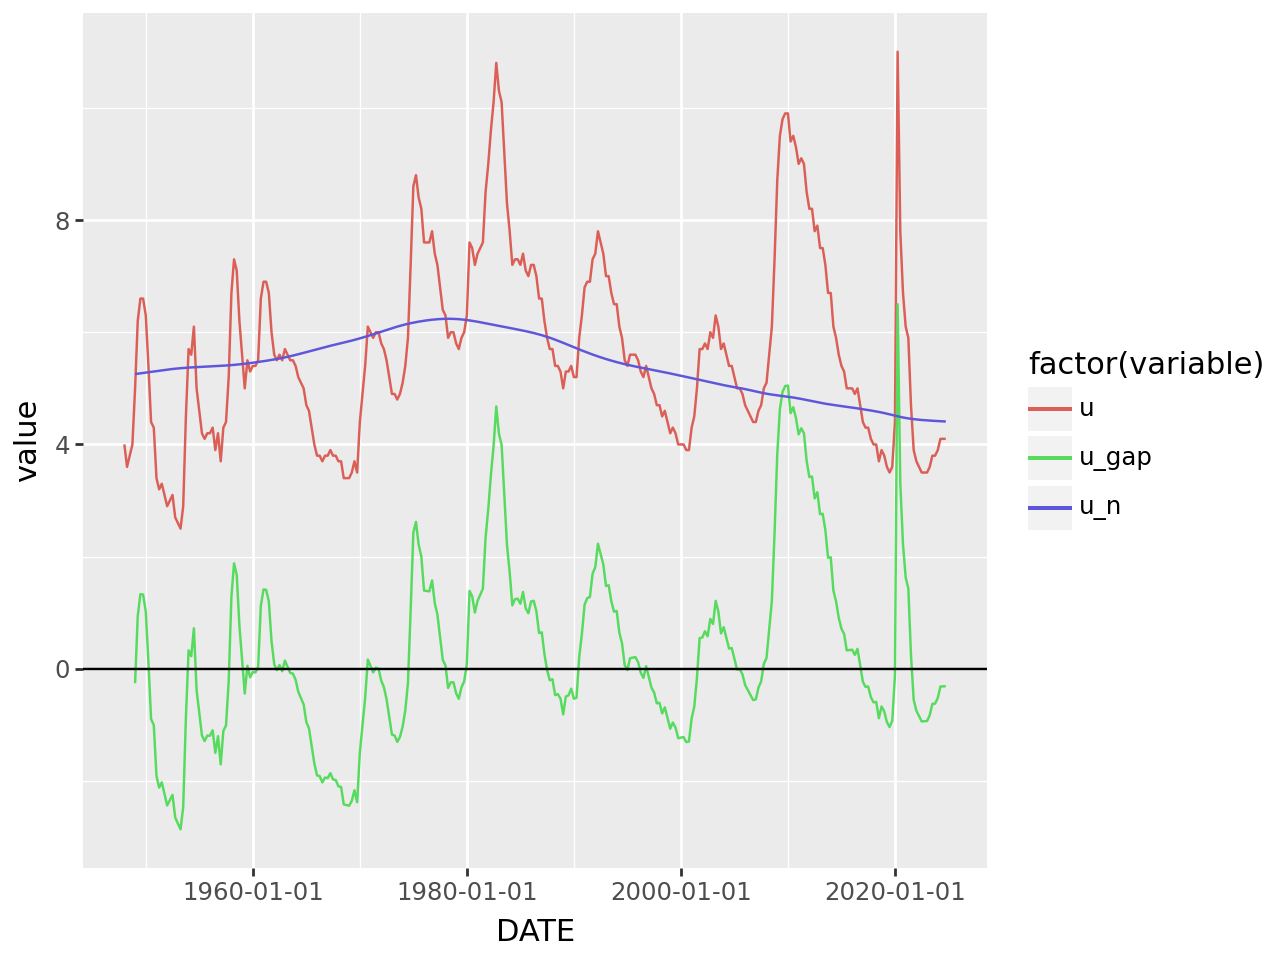

In [145]:
u_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['u', 'u_n', 'u_gap']).dropna()

(
    p9.ggplot(u_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Supply shocks

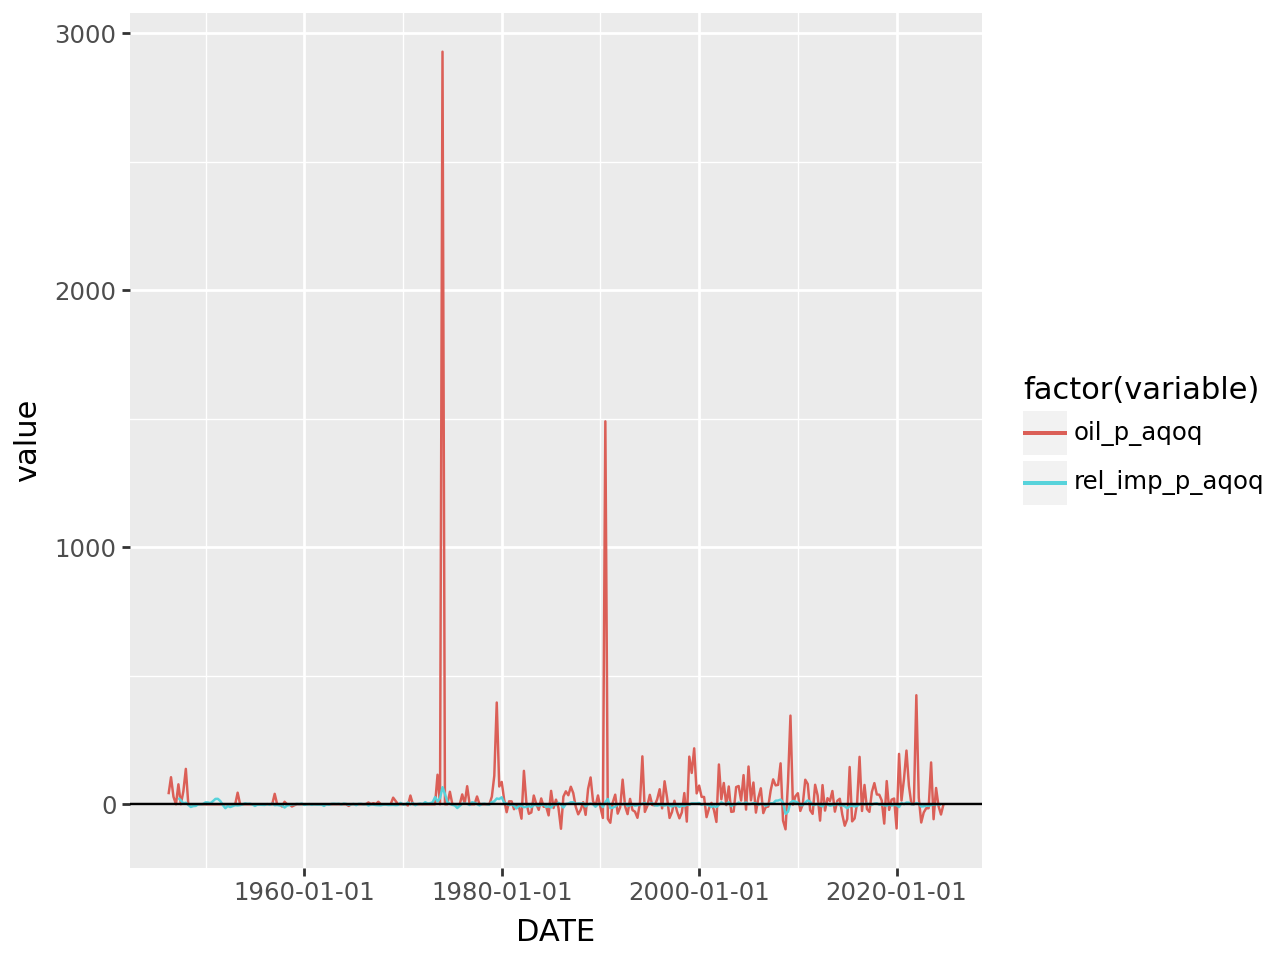

In [146]:
ip_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['rel_imp_p_aqoq', 'oil_p_aqoq']).dropna()

(
    p9.ggplot(ip_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Select Model Variables

In [147]:
model_2025_df = df[['cpi_aqoq', 'cpi_aqoq_meb', 'u', 'u_n', 'u_gap', 'e_p_cpi_1', 'e_p_cpi_1_meb', 'e_h_cpi_1', 'e_h_cpi_1_meb', 'rel_imp_p_aqoq', 'oil_p_aqoq', 'e_b_cpi']].dropna()
model_2016_df = model_2025_df.loc[model_2025_df.index < '2016-01-01',:]

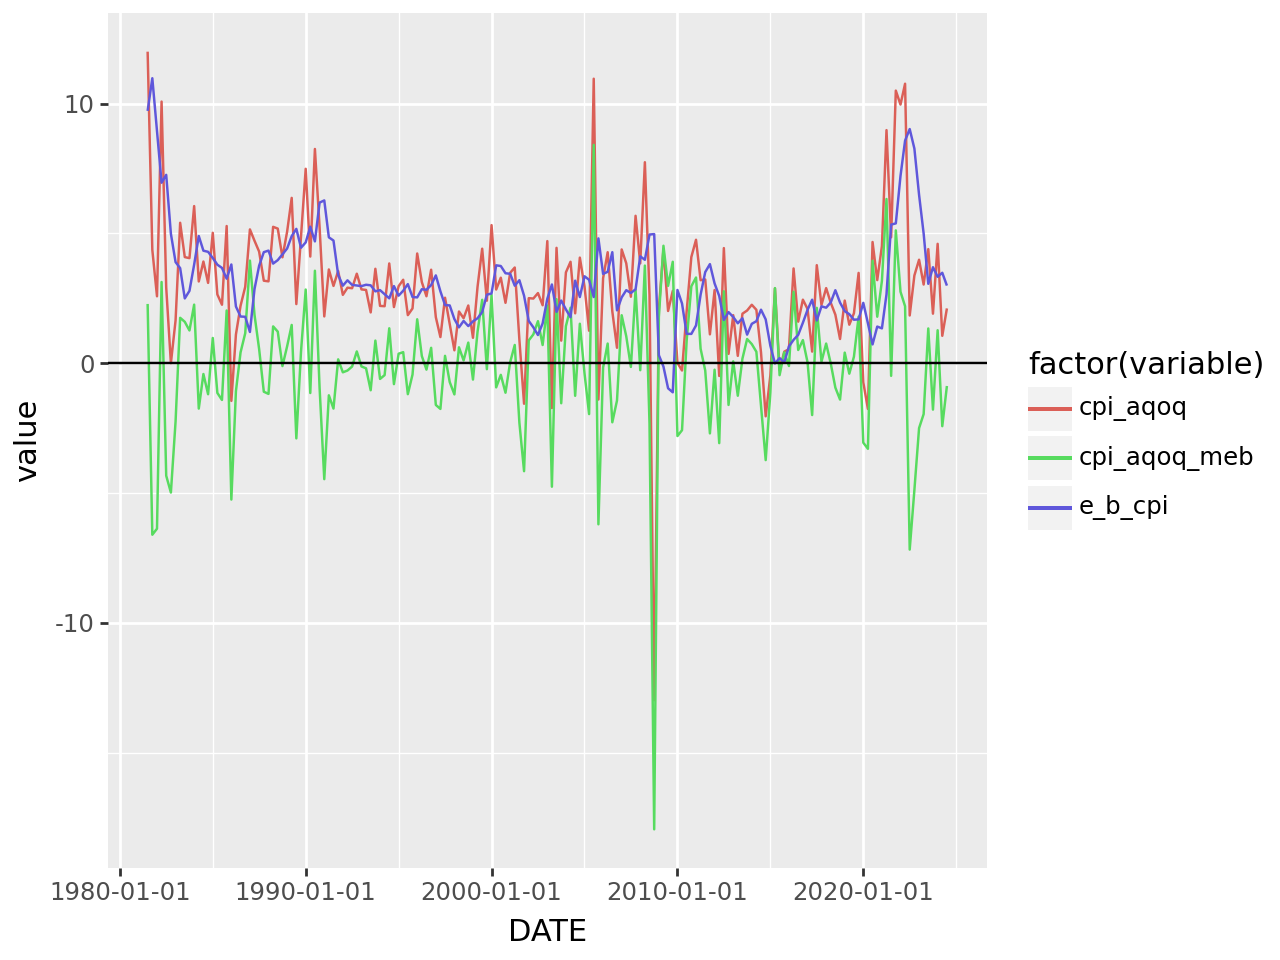

In [148]:
cpi_df_long = pd.melt(model_2025_df.reset_index(), id_vars=['DATE'], value_vars=['cpi_aqoq', 'cpi_aqoq_meb', 'e_b_cpi']).dropna()

(
    p9.ggplot(cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

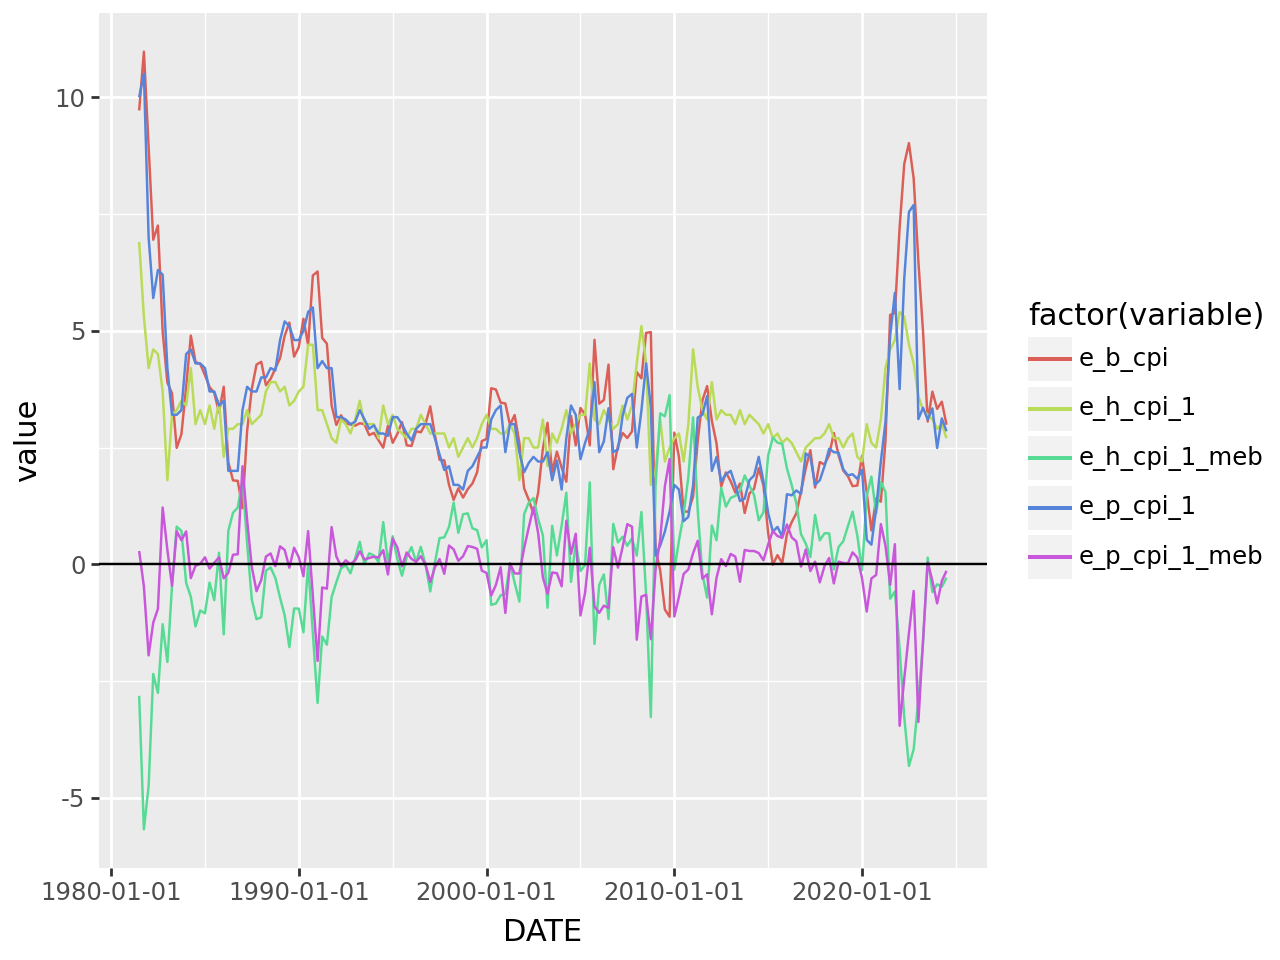

In [149]:
e_cpi_df_long = pd.melt(model_2025_df.reset_index(), id_vars=['DATE'], value_vars=['e_p_cpi_1', 'e_p_cpi_1_meb', 'e_h_cpi_1', 'e_h_cpi_1_meb', 'e_b_cpi']).dropna()

(
    p9.ggplot(e_cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

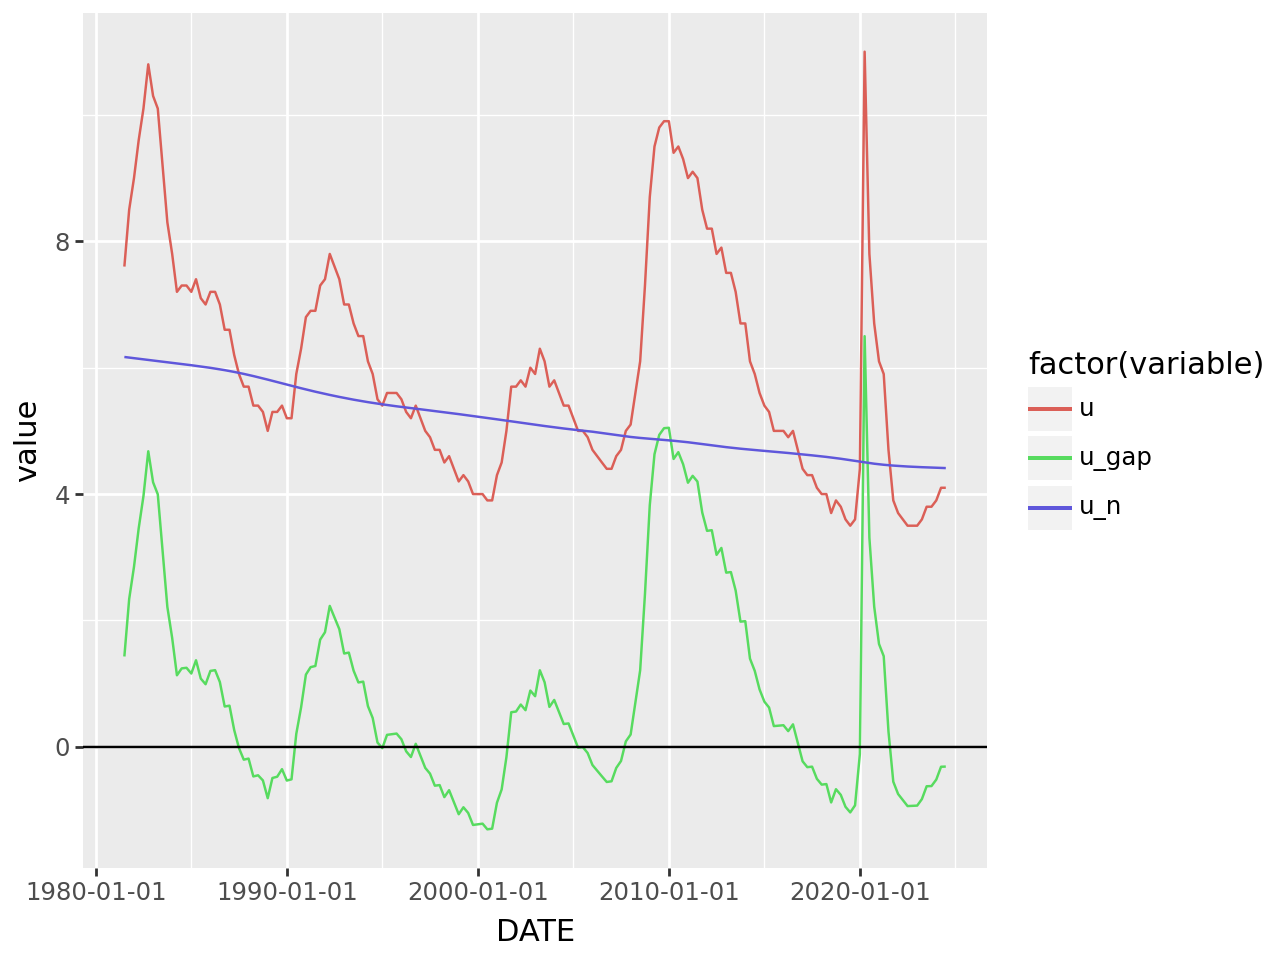

In [150]:
u_df_long = pd.melt(model_2025_df.reset_index(), id_vars=['DATE'], value_vars=['u', 'u_n', 'u_gap']).dropna()

(
    p9.ggplot(u_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

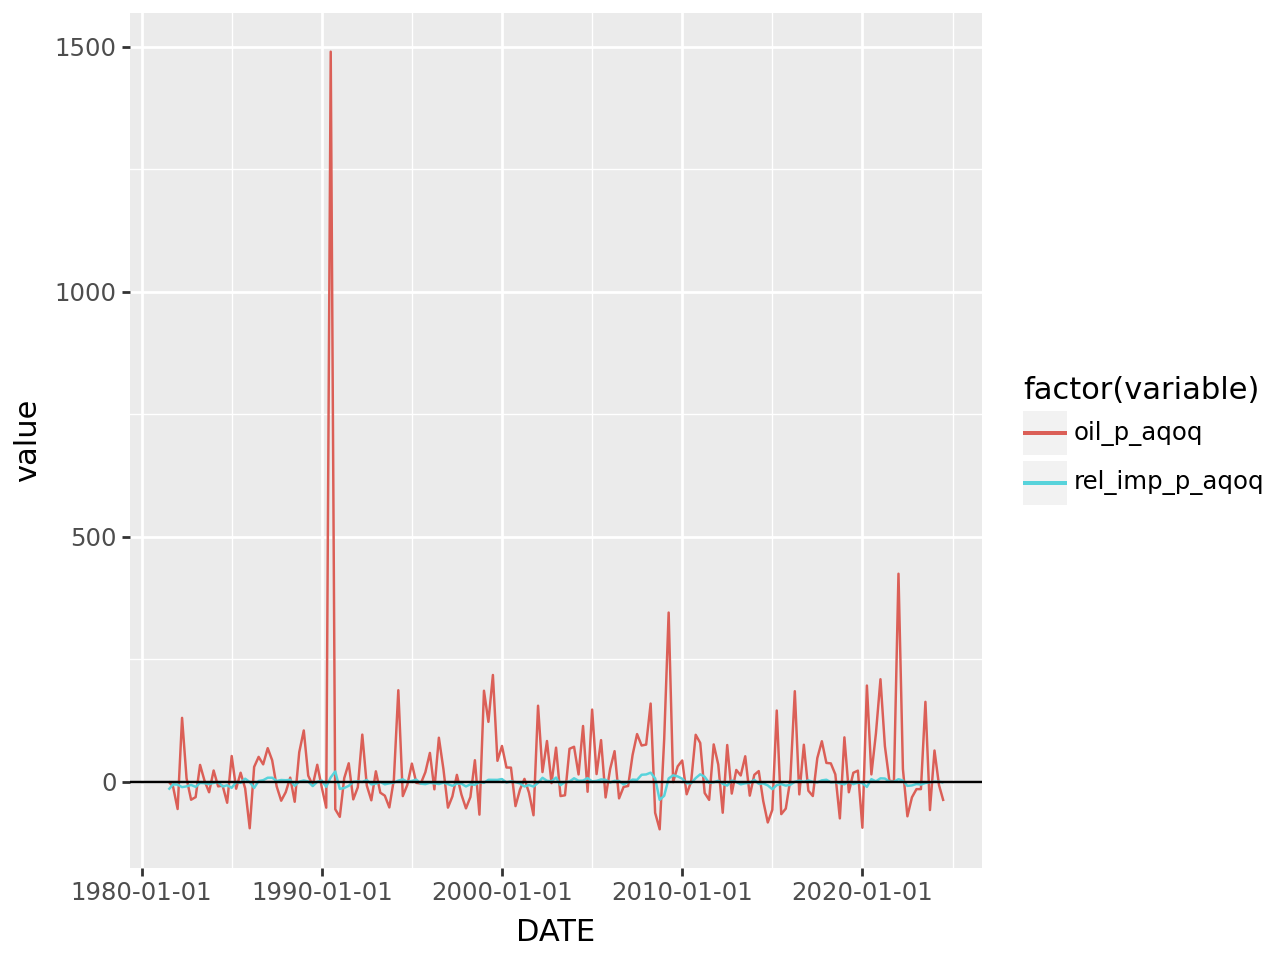

In [151]:
ip_df_long = pd.melt(model_2025_df.reset_index(), id_vars=['DATE'], value_vars=['rel_imp_p_aqoq', 'oil_p_aqoq']).dropna()

(
    p9.ggplot(ip_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

## Model

The state space model is specified in the original paper in appendix A.

In [152]:
from pymc.model import modelcontext

from pymc_extras.statespace.utils.constants import (
    ALL_STATE_DIM,
    ALL_STATE_AUX_DIM,
    OBS_STATE_DIM,
    SHOCK_DIM,
    TIME_DIM,
)
from pymc_extras.statespace.core.statespace import PyMCStateSpace
from pymc_extras.statespace.models.utilities import make_default_coords

class VlekkeKoopmanMellens2021(PyMCStateSpace):
    def __init__(self):
        k_states = 5 # size of the state vector x
        k_posdef = 5 # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        exog_data = self.make_and_register_data('exog_data', shape=(None, self.k_states))
        x0 = self.make_and_register_variable('x0', shape=(self.k_states,))
        P0 = self.make_and_register_variable('P0', shape=(self.k_states, self.k_states))
        h = self.make_and_register_variable('h', shape=(None, self.k_endog))
        sigma_sq_eta = self.make_and_register_variable('sigma_sq_eta', shape=(self.k_posdef,))

        self.ssm['transition', :, :] = np.eye(self.k_states)
        assert self.k_states == self.k_posdef
        self.ssm['selection', :, :] = np.eye(self.k_states, self.k_posdef)

        self.ssm['initial_state', :] = x0
        self.ssm['initial_state_cov', :, :] = P0
        self.ssm['design'] = pt.expand_dims(exog_data, 1)  
        self.ssm['obs_cov'] = pt.vectorize(pt.diag, '(a)->(a,b)')(pt.exp(h))
        self.ssm['state_cov', *np.diag_indices(self.k_posdef)] = sigma_sq_eta

    @property
    def param_names(self):
        return ['x0', 'P0', 'h', 'sigma_sq_eta']

    @property
    def state_names(self):
        return ['beta', 'theta', 'phi', 'gamma_1', 'gamma_2']

    @property
    def shock_names(self):
        return [f'{state}_shock' for state in self.state_names]

    @property
    def observed_states(self):
        return ['pi']

    @property
    def param_dims(self):
        return {
            'x0': (ALL_STATE_DIM,),
            'P0': (ALL_STATE_DIM, ALL_STATE_AUX_DIM),
            'h': (TIME_DIM, OBS_STATE_DIM),
            'sigma_sq_eta': (SHOCK_DIM,),
        }

    @property
    def coords(self):
        coords = make_default_coords(self)
        coords.update({'exog_data_dim': ['u_gap', 'pi_p', 'pi_h', 'rel_i_p', 'oil_p']})

        return coords

    @property
    def param_info(self):
        info = {
            'x0': {
                'shape': (self.k_states,),
                'constraints': 'None',
            },
            'P0': {
                'shape': (self.k_states, self.k_states),
                'constraints': 'Positive Semi-definite',
            },
            'h': {
                'shape': (None, self.k_endog),
                'constraints': 'Time-varying',
            },
            'sigma_sq_eta': {
                'shape': (self.k_posdef,),
                'constraints': 'Positive',
            },
        }

        for name in self.param_names:
            info[name]['dims'] = self.param_dims[name]

        return info

    @property
    def data_names(self):
        return ['exog_data']
    
    @property
    def data_info(self):
        return {
            'exog_data': {
                'shape': (None, self.k_states),
                'dims': (TIME_DIM, 'exog_data_dim')
            }
        }

### Model Priors

Get priors for the initial state ($b_{40} = [\beta_t, \theta_t, \theta_t, \gamma_t, \gamma_t]$, $P_{40}$) as described in section 2.2 of the reference paper. We estimate equation (7) with maximum likelihood:
$$\pi_t = \beta_t (u_t - u_t^*) + \theta_t \pi_t^{e,P} + (1-\theta_t) \pi_t^{e,B} + \gamma_t \pi_t^M + \varepsilon_t \tag{7}$$
$$\pi_t^{e,B} = \frac{1}{4} \sum_{i=1}^4 \pi_{t-i}$$
$$\implies \pi_t - \pi_t^{e,B} = \beta_t (u_t - u_t^*) + \theta_t (\pi_t^{e,P} - \pi_t^{e,B}) + \gamma_t \pi_t^M + \varepsilon_t$$

In [153]:
import statsmodels.api as sm

# Take first 40 observations
prior_df = model_2025_df.head(40)

y = prior_df[['cpi_aqoq_meb']]
X = sm.add_constant(prior_df[['u_gap', 'e_p_cpi_1_meb', 'rel_imp_p_aqoq']])

results = sm.OLS(y, X).fit()
print(results.summary())

# Map the found priors to the model parameters
idx_map = [1, 2, 2, 3, 3]
b_40 = np.take(results.params.values, idx_map)
P_40 = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        P_40[i,j] = results.cov_params().values[idx_map[i], idx_map[j]]

print('b_40:', b_40)
print('P_40:', P_40)

                            OLS Regression Results                            
Dep. Variable:           cpi_aqoq_meb   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     6.428
Date:                Sun, 12 Jan 2025   Prob (F-statistic):            0.00134
Time:                        22:52:03   Log-Likelihood:                -87.016
No. Observations:                  40   AIC:                             182.0
Df Residuals:                      36   BIC:                             188.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1889      0.454      0.

In [154]:
# TODO prior predictive checks?

### Model Fit Using Similar Priors to the Reference Paper

In [155]:
def plot_latent_states(cond_post, states=['beta', 'theta', 'phi', 'gamma_1', 'gamma_2']):
    fig, ax = plt.subplots(5, 1, figsize=(14, 4*len(states)))

    x_values = cond_post.coords['time']
    
    for axis, name in zip(fig.axes, states):
        data = cond_post.smoothed_posterior.sel(state=name)
        hdi = az.hdi(data).smoothed_posterior
        mean = data.median(dim=['chain', 'draw'])
    
        axis.plot(x_values, mean)
        axis.fill_between(x_values, *hdi.values.T, color='tab:blue', alpha=0.1)
        axis.hlines(y=0., xmin=x_values.min(), xmax=x_values.max(), linestyle='--', linewidth=0.5, color='black')
        axis.set_title(name)
        
    plt.show()

def figure_4_3_a(model_df, cond_post, ylim=(-1.5, 1.5)):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    x_values = cond_post.coords['time']
    
    ax.plot(x_values, model_df['cpi_aqoq'] / 10, color='gray')
    ax.plot(x_values, model_df['e_p_cpi_1'] / 10, color='blue', linestyle='dashed')
    ax.plot(x_values, model_df['e_h_cpi_1'] / 10, color='red', linestyle='dashed')
    ax.plot(x_values, cond_post.smoothed_posterior.sel(state='beta').median(dim=['chain', 'draw']), color='black')
    ax.plot(x_values, cond_post.smoothed_posterior.sel(state='theta').median(dim=['chain', 'draw']), color='blue')
    ax.plot(x_values, cond_post.smoothed_posterior.sel(state='phi').median(dim=['chain', 'draw']), color='red')
    ax.hlines(y=0, xmin=x_values.min(), xmax=x_values.max(), color='gray')
    plt.xlim(x_values.min(), x_values.max())
    plt.ylim(ylim[0], ylim[1])
    plt.show()

In [209]:
def model_1(model_df, b_40, P_40):
    """
    Model with more restrictive priors, trying to emulate the priors from the paper
    """
    exog_data_df = model_df[['u_gap', 'e_p_cpi_1_meb', 'e_h_cpi_1_meb', 'rel_imp_p_aqoq', 'oil_p_aqoq']]
    obs_df = model_df[['cpi_aqoq_meb']]
    
    vkm = VlekkeKoopmanMellens2021()
    
    h0_mu, h0_sigma = 0.0, 0.5
    
    with pm.Model(coords=vkm.coords) as mod:
        x0 = pm.Deterministic('x0', pt.as_tensor(b_40), dims=[ALL_STATE_DIM])
        P0 = pm.Deterministic('P0', pt.as_tensor(P_40), dims=[ALL_STATE_DIM, ALL_STATE_AUX_DIM])
        h0 = pm.Normal.dist(mu=h0_mu, sigma=h0_sigma)
    
        # For sigma_sq_nu and sigma_sq_eta priors, see table 2 in appendix C in the refrence paper
        sigma_sq_nu = pm.InverseGamma('sigma_sq_nu', alpha=(vkm.k_states + 2) / 2, beta=0.454 / 2)
        sigma_sq_eta = pm.InverseGamma('sigma_sq_eta', alpha=(vkm.k_states + 2) / 2, beta=0.268 / 2, dims=[SHOCK_DIM])
    
        h = pm.GaussianRandomWalk('h', sigma=pt.sqrt(sigma_sq_nu), init_dist=h0, shape=obs_df.shape, dims=[TIME_DIM, OBS_STATE_DIM])
        sigma_sq_eps = pm.Deterministic('sigma_sq_eps', pt.exp(h), dims=[TIME_DIM, OBS_STATE_DIM])
        
        exog_data = pm.Data("exog_data", exog_data_df, dims=['time', 'exog_data_dim'])
    
        vkm.build_statespace_graph(data=obs_df, mode="JAX")
        idata = pm.sample(nuts_sampler="numpyro", chains=8, draws=1000)

    return vkm, idata

def model_2(model_df):
    """
    Model with weakly informative priors
    """
    exog_data_df = model_df[['u_gap', 'e_p_cpi_1_meb', 'e_h_cpi_1_meb', 'rel_imp_p_aqoq', 'oil_p_aqoq']]
    obs_df = model_df[['cpi_aqoq_meb']]
    
    vkm = VlekkeKoopmanMellens2021()
    
    b_40 = np.zeros(5, dtype="float")
    P_40 = np.eye(5) * 0.5
    h0_mu, h0_sigma = 0.0, 0.5
    
    with pm.Model(coords=vkm.coords) as mod:
        x0 = pm.Deterministic('x0', pt.as_tensor(b_40))
        P0 = pm.Deterministic('P0', pt.as_tensor(P_40), dims=[ALL_STATE_DIM, ALL_STATE_AUX_DIM])
        h0 = pm.Normal.dist(mu=h0_mu, sigma=h0_sigma)

        sigma_sq_nu = pm.Exponential('sigma_sq_nu', 1)
        sigma_sq_eta = pm.Exponential('sigma_sq_eta', 1, dims=[SHOCK_DIM])
        h = pm.GaussianRandomWalk('h', sigma=pt.sqrt(sigma_sq_nu), init_dist=h0, shape=obs_df.shape, dims=[TIME_DIM, OBS_STATE_DIM])
        sigma_sq_eps = pm.Deterministic('sigma_sq_eps', pt.exp(h), dims=[TIME_DIM, OBS_STATE_DIM])
        
        exog_data = pm.Data("exog_data", exog_data_df, dims=['time', 'exog_data_dim'])
    
        vkm.build_statespace_graph(data=obs_df, mode="JAX")
        idata = pm.sample(nuts_sampler="numpyro", chains=8, draws=1000)

    return vkm, idata

In [157]:
#az.plot_pair(idata, var_names=['sigma_sq_eps', 'sigma_sq_eta'], divergences=True)
#plt.show()

#### 1981-2016

In [158]:
vkm_2016, idata_2016 = model_1(model_2016_df, b_40, P_40)

                                Model Requirements                                
                                                                                  
  Variable       Shape       Constraints                              Dimensions  
 ──────────────────────────────────────────────────────────────────────────────── 
  x0             (5,)        None                                     ('state',)  
  P0             (5, 5)      Positive Semi-definite       ('state', 'state_aux')  
  h              (None, 1)   Time-varying             ('time', 'observed_state')  
  sigma_sq_eta   (5,)        Positive                                 ('shock',)  
                                                                                  
  exog_data      (None, 5)   pm.Data                   ('time', 'exog_data_dim')  
                                                                                  
   These parameters should be assigned priors inside a PyMC model block before    
                    calling the build_statespace_graph method.                    

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [159]:
az.summary(idata_2016, var_names=['h', 'sigma_sq_eps', 'sigma_sq_eta'])

mean     sd  hdi_3%  hdi_97%  \
h[1981-07-01T00:00:00.000000000, pi]  1.022  0.385   0.320    1.767   
h[1981-10-01T00:00:00.000000000, pi] -0.021  0.503  -0.952    0.916   
h[1982-01-01T00:00:00.000000000, pi] -0.005  0.498  -0.903    0.994   
h[1982-04-01T00:00:00.000000000, pi] -0.005  0.507  -0.934    0.955   
h[1982-07-01T00:00:00.000000000, pi] -0.013  0.493  -0.964    0.886   
...                                     ...    ...     ...      ...   
sigma_sq_eta[beta_shock]              0.027  0.012   0.010    0.048   
sigma_sq_eta[theta_shock]             0.040  0.023   0.012    0.079   
sigma_sq_eta[phi_shock]               0.034  0.016   0.011    0.063   
sigma_sq_eta[gamma_1_shock]           0.014  0.004   0.008    0.021   
sigma_sq_eta[gamma_2_shock]           0.004  0.001   0.003    0.005   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
h[1981-07-01T00:00:00.000000000, pi]      0.004    0.003   11552.0    5483.0   
h[1981-10-01T00:00:00.000000000, pi]      0.004    0.007   13062.0    5213.0   
h[1982-01-01T00:00:00.000000000, pi]      0.005    0.006   11350.0    5395.0   
h[1982-04-01T00:00:00.000000000, pi]      0.005    0.006   12512.0    5786.0   
h[1982-07-01T00:00:00.000000000, pi]      0.005    0.006   11681.0    5538.0   
...                                         ...      ...       ...       ...   
sigma_sq_eta[beta_shock]                  0.000    0.000   10804.0    5498.0   
sigma_sq_eta[theta_shock]                 0.000    0.000   12146.0    5327.0   
sigma_sq_eta[phi_shock]                   0.000    0.000   10549.0    5147.0   
sigma_sq_eta[gamma_1_shock]               0.000    0.000   12039.0    5721.0   
sigma_sq_eta[gamma_2_shock]               0.000    0.000   10991.0    5756.0   

                                      r_hat  
h[1981-07-01T00:00:00.000000000, pi]    1.0  
h[1981-10-01T00:00:00.000000000, pi]    1.0  
h[1982-01-01T00:00:00.000000000, pi]    1.0  
h[1982-04-01T00:00:00.000000000, pi]    1.0  
h[1982-07-01T00:00:00.000000000, pi]    1.0  
...                                     ...  
sigma_sq_eta[beta_shock]                1.0  
sigma_sq_eta[theta_shock]               1.0  
sigma_sq_eta[phi_shock]                 1.0  
sigma_sq_eta[gamma_1_shock]             1.0  
sigma_sq_eta[gamma_2_shock]             1.0  

[281 rows x 9 columns]

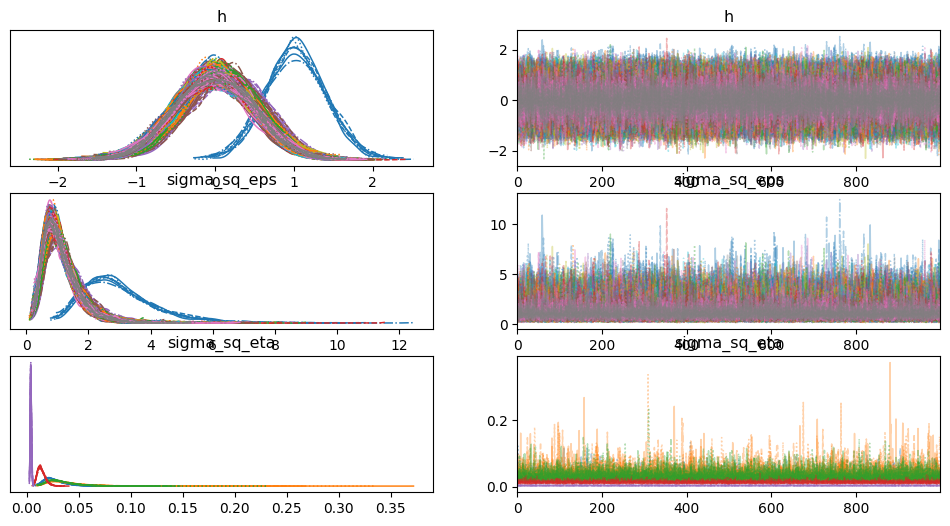

In [160]:
az.plot_trace(idata_2016, var_names=['h', 'sigma_sq_eps', 'sigma_sq_eta'])
plt.show()

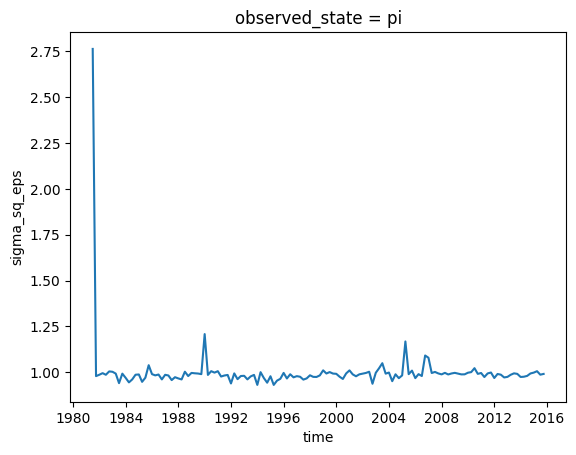

In [161]:
idata_2016.posterior['sigma_sq_eps'].median(['chain', 'draw']).plot()
plt.show()

In [162]:
cond_post_2016 = vkm_2016.sample_conditional_posterior(idata_2016)

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F00DC9AAC00>), RNG(<Generator(PCG64) at 0x7F00DC9AAB20>), RNG(<Generator(PCG64) at 0x7F00DC9AB140>), RNG(<Generator(PCG64) at 0x7F00DC9AAEA0>), RNG(<Generator(PCG64) at 0x7F00DC9AB220>), RNG(<Generator(PCG64) at 0x7F00DC327680>)] will not be used in the compiled JAX graph. Instead a copy will be used.
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

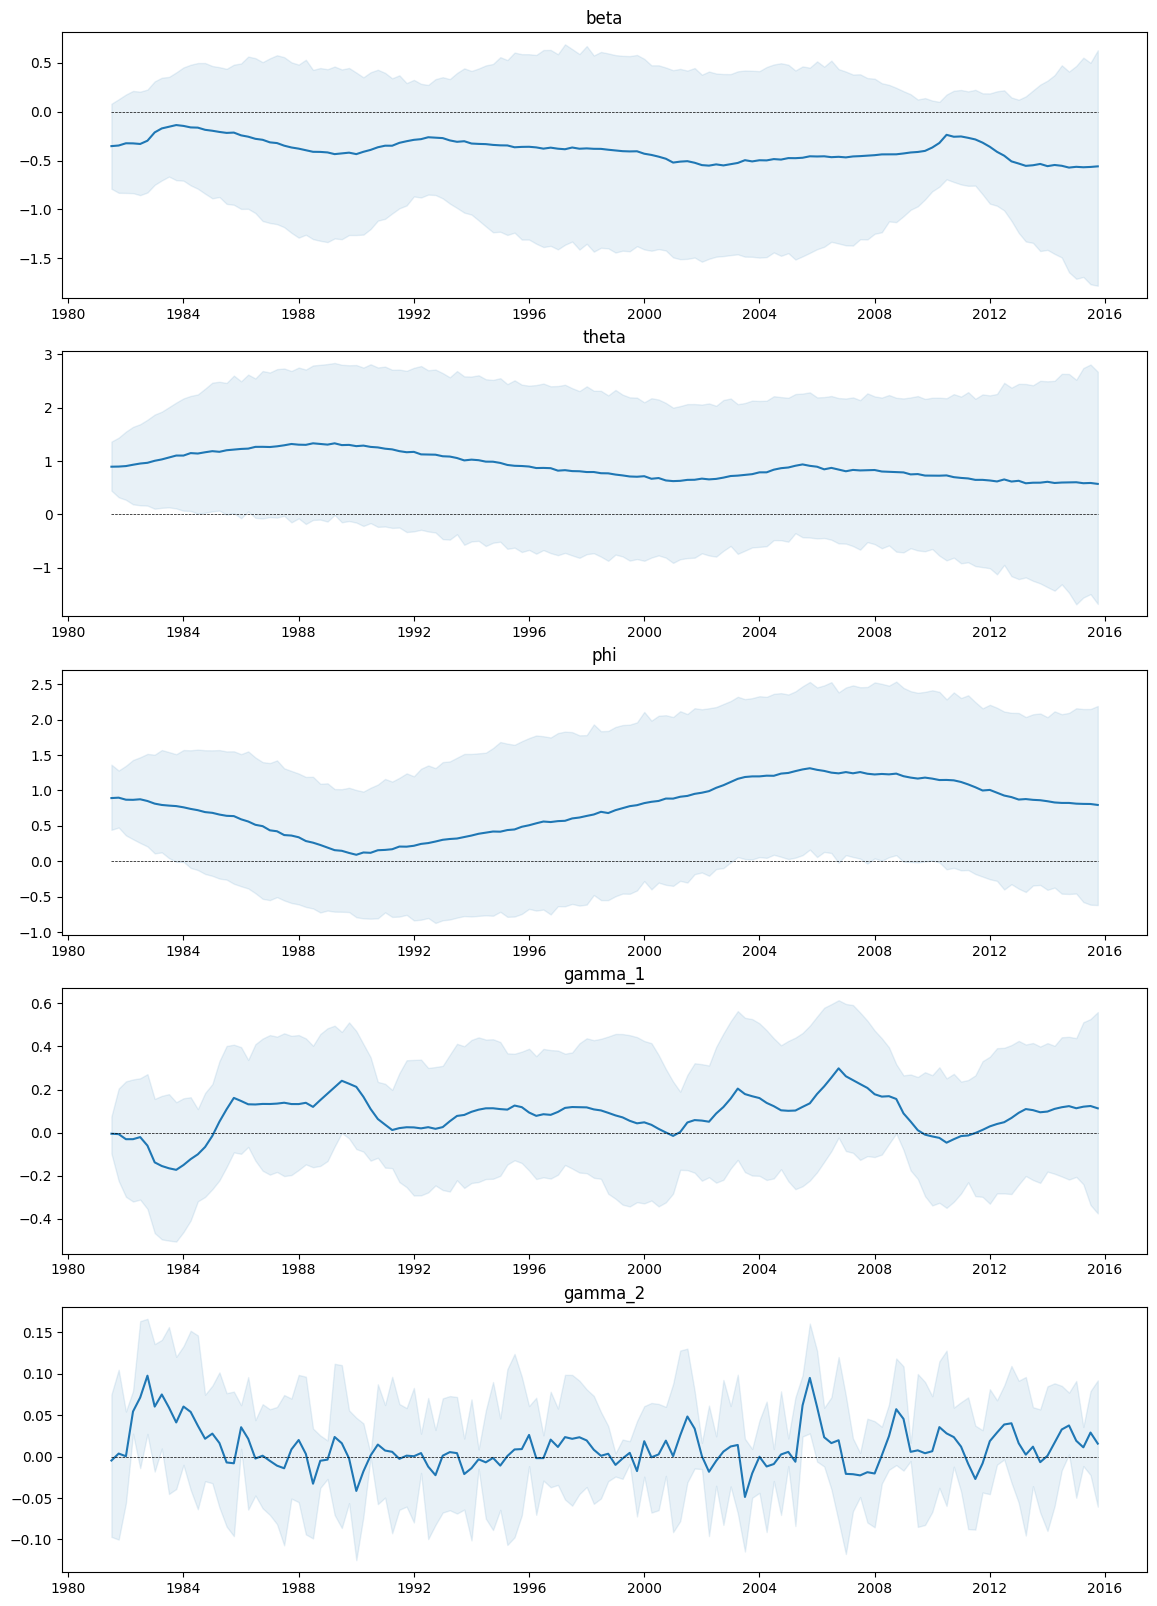

In [163]:
plot_latent_states(cond_post_2016)

#### 1981-2025

In [164]:
vkm, idata = model_1(model_2025_df, b_40, P_40)

                                Model Requirements                                
                                                                                  
  Variable       Shape       Constraints                              Dimensions  
 ──────────────────────────────────────────────────────────────────────────────── 
  x0             (5,)        None                                     ('state',)  
  P0             (5, 5)      Positive Semi-definite       ('state', 'state_aux')  
  h              (None, 1)   Time-varying             ('time', 'observed_state')  
  sigma_sq_eta   (5,)        Positive                                 ('shock',)  
                                                                                  
  exog_data      (None, 5)   pm.Data                   ('time', 'exog_data_dim')  
                                                                                  
   These parameters should be assigned priors inside a PyMC model block before    
                    calling the build_statespace_graph method.                    

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [165]:
az.summary(idata, var_names=['h', 'sigma_sq_eps', 'sigma_sq_eta'])

mean     sd  hdi_3%  hdi_97%  \
h[1981-07-01T00:00:00.000000000, pi]  1.020  0.382   0.306    1.743   
h[1981-10-01T00:00:00.000000000, pi] -0.013  0.490  -0.931    0.913   
h[1982-01-01T00:00:00.000000000, pi] -0.010  0.493  -0.920    0.940   
h[1982-04-01T00:00:00.000000000, pi] -0.002  0.517  -0.970    0.970   
h[1982-07-01T00:00:00.000000000, pi] -0.018  0.496  -0.993    0.884   
...                                     ...    ...     ...      ...   
sigma_sq_eta[beta_shock]              0.026  0.011   0.011    0.045   
sigma_sq_eta[theta_shock]             0.036  0.019   0.012    0.068   
sigma_sq_eta[phi_shock]               0.032  0.014   0.012    0.059   
sigma_sq_eta[gamma_1_shock]           0.013  0.004   0.007    0.020   
sigma_sq_eta[gamma_2_shock]           0.003  0.000   0.003    0.004   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
h[1981-07-01T00:00:00.000000000, pi]      0.003    0.002   19674.0    5548.0   
h[1981-10-01T00:00:00.000000000, pi]      0.004    0.007   16991.0    5534.0   
h[1982-01-01T00:00:00.000000000, pi]      0.003    0.006   20010.0    5494.0   
h[1982-04-01T00:00:00.000000000, pi]      0.004    0.007   17686.0    5145.0   
h[1982-07-01T00:00:00.000000000, pi]      0.004    0.006   18210.0    5867.0   
...                                         ...      ...       ...       ...   
sigma_sq_eta[beta_shock]                  0.000    0.000   17095.0    5371.0   
sigma_sq_eta[theta_shock]                 0.000    0.000   19023.0    5026.0   
sigma_sq_eta[phi_shock]                   0.000    0.000   17128.0    5675.0   
sigma_sq_eta[gamma_1_shock]               0.000    0.000   16445.0    5012.0   
sigma_sq_eta[gamma_2_shock]               0.000    0.000   16864.0    5376.0   

                                      r_hat  
h[1981-07-01T00:00:00.000000000, pi]    1.0  
h[1981-10-01T00:00:00.000000000, pi]    1.0  
h[1982-01-01T00:00:00.000000000, pi]    1.0  
h[1982-04-01T00:00:00.000000000, pi]    1.0  
h[1982-07-01T00:00:00.000000000, pi]    1.0  
...                                     ...  
sigma_sq_eta[beta_shock]                1.0  
sigma_sq_eta[theta_shock]               1.0  
sigma_sq_eta[phi_shock]                 1.0  
sigma_sq_eta[gamma_1_shock]             1.0  
sigma_sq_eta[gamma_2_shock]             1.0  

[351 rows x 9 columns]

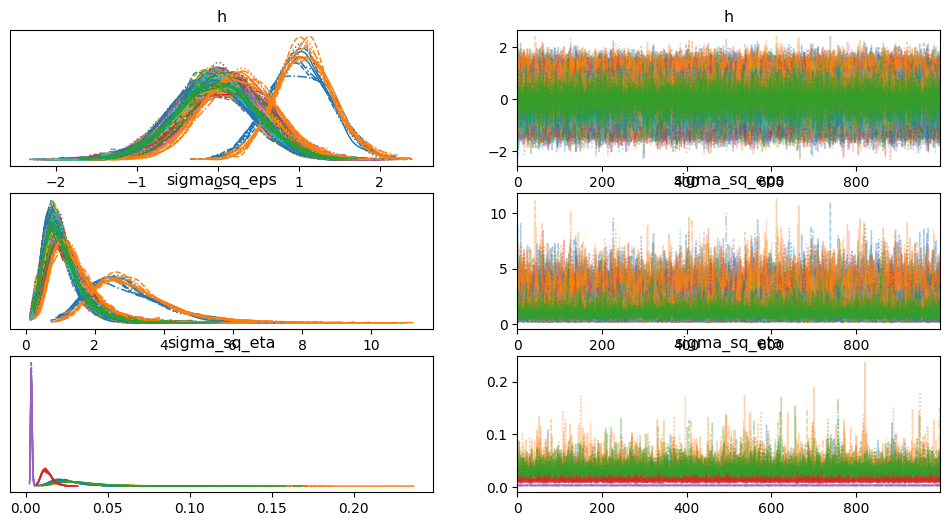

In [166]:
az.plot_trace(idata, var_names=['h', 'sigma_sq_eps', 'sigma_sq_eta'])
plt.show()

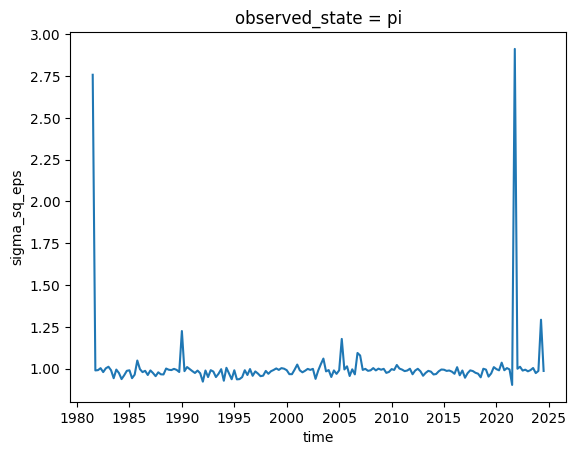

In [167]:
idata.posterior['sigma_sq_eps'].median(['chain', 'draw']).plot()
plt.show()

In [168]:
cond_post = vkm.sample_conditional_posterior(idata)

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F00D7DFC900>), RNG(<Generator(PCG64) at 0x7F00D7DFC9E0>), RNG(<Generator(PCG64) at 0x7F00D7DFC740>), RNG(<Generator(PCG64) at 0x7F00D7DFC820>), RNG(<Generator(PCG64) at 0x7F00D7DFCAC0>), RNG(<Generator(PCG64) at 0x7F00CCA6A180>)] will not be used in the compiled JAX graph. Instead a copy will be used.
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

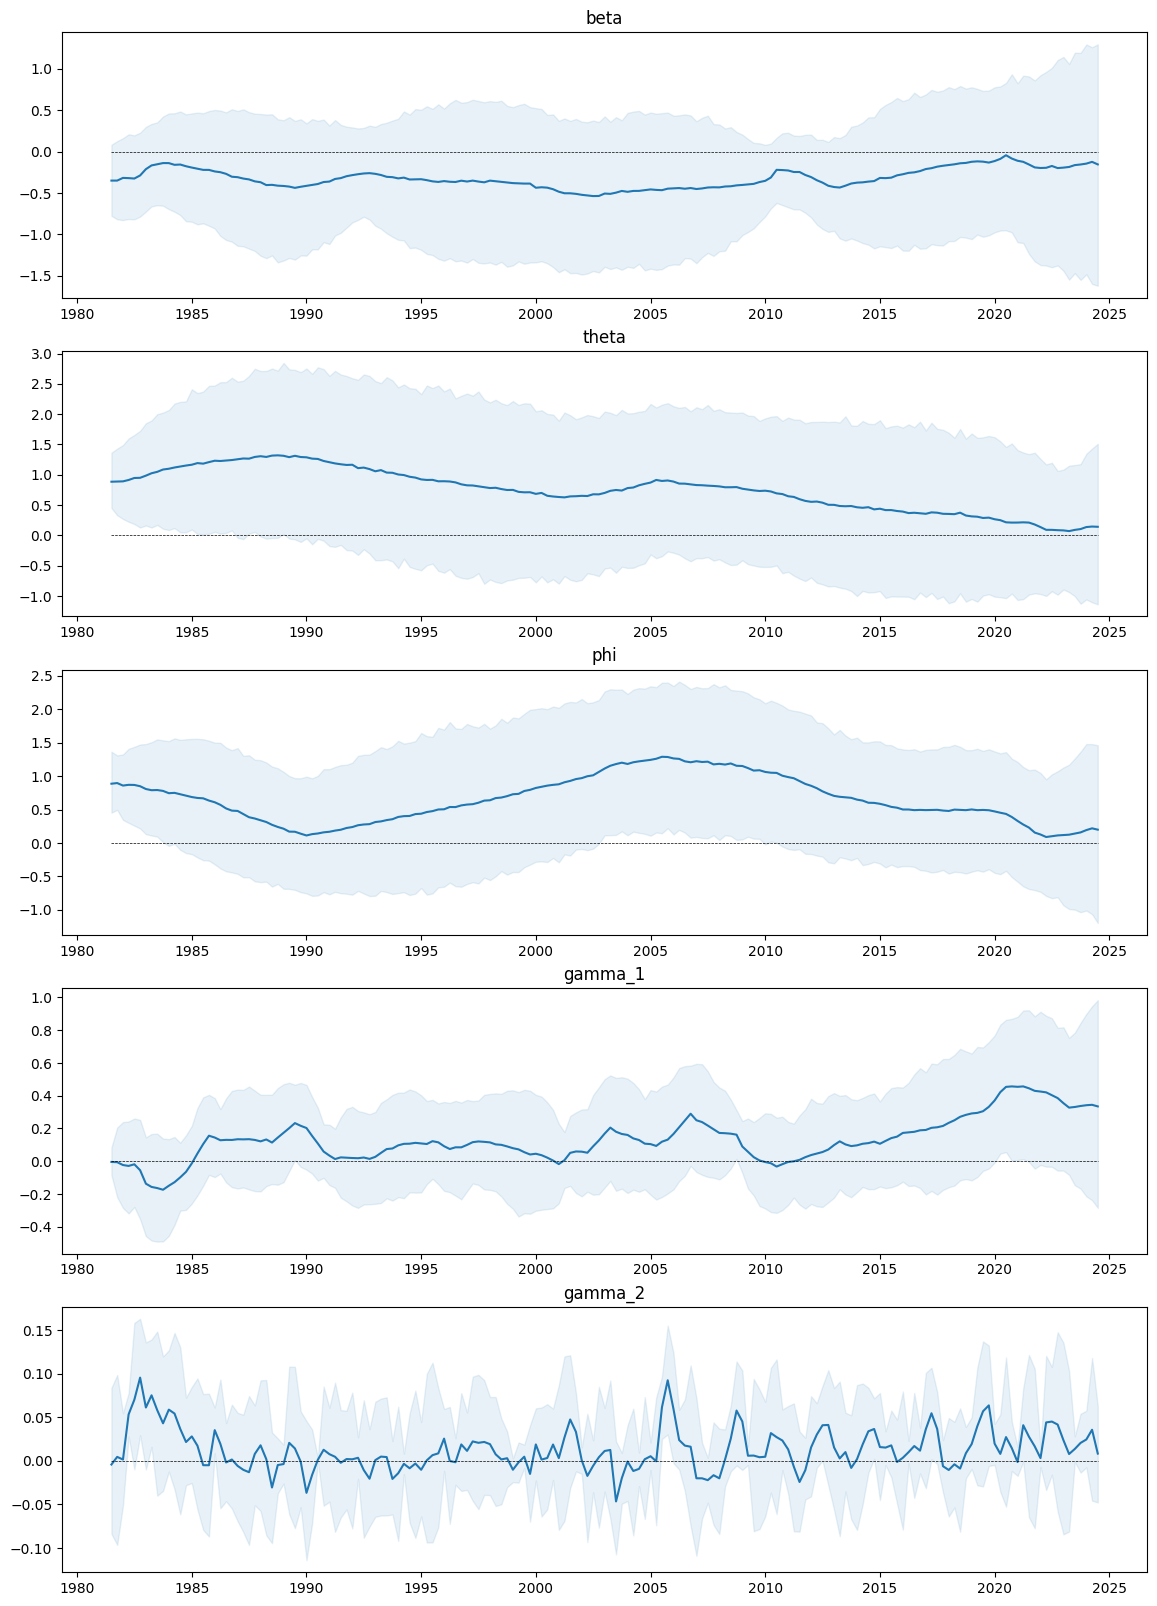

In [169]:
plot_latent_states(cond_post)

### Model Fit Using Weakly Informative Priors

#### 1981-2016

In [210]:
vkm_2016_2, idata_2016_2 = model_2(model_2016_df)

                                Model Requirements                                
                                                                                  
  Variable       Shape       Constraints                              Dimensions  
 ──────────────────────────────────────────────────────────────────────────────── 
  x0             (5,)        None                                     ('state',)  
  P0             (5, 5)      Positive Semi-definite       ('state', 'state_aux')  
  h              (None, 1)   Time-varying             ('time', 'observed_state')  
  sigma_sq_eta   (5,)        Positive                                 ('shock',)  
                                                                                  
  exog_data      (None, 5)   pm.Data                   ('time', 'exog_data_dim')  
                                                                                  
   These parameters should be assigned priors inside a PyMC model block before    
                    calling the build_statespace_graph method.                    

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [211]:
az.summary(idata_2016_2, var_names=['sigma_sq_eps', 'sigma_sq_eta'])

mean     sd  hdi_3%  \
sigma_sq_eps[1981-07-01T00:00:00.000000000, pi]  1.239  0.685   0.270   
sigma_sq_eps[1981-10-01T00:00:00.000000000, pi]  1.173  0.615   0.308   
sigma_sq_eps[1982-01-01T00:00:00.000000000, pi]  1.108  0.579   0.275   
sigma_sq_eps[1982-04-01T00:00:00.000000000, pi]  1.143  0.613   0.261   
sigma_sq_eps[1982-07-01T00:00:00.000000000, pi]  1.138  0.591   0.292   
...                                                ...    ...     ...   
sigma_sq_eta[beta_shock]                         0.039  0.033   0.000   
sigma_sq_eta[theta_shock]                        0.110  0.119   0.000   
sigma_sq_eta[phi_shock]                          0.138  0.090   0.016   
sigma_sq_eta[gamma_1_shock]                      0.002  0.002   0.000   
sigma_sq_eta[gamma_2_shock]                      0.000  0.000   0.000   

                                                 hdi_97%  mcse_mean  mcse_sd  \
sigma_sq_eps[1981-07-01T00:00:00.000000000, pi]    2.480      0.006    0.006   
sigma_sq_eps[1981-10-01T00:00:00.000000000, pi]    2.316      0.006    0.006   
sigma_sq_eps[1982-01-01T00:00:00.000000000, pi]    2.169      0.005    0.005   
sigma_sq_eps[1982-04-01T00:00:00.000000000, pi]    2.235      0.006    0.006   
sigma_sq_eps[1982-07-01T00:00:00.000000000, pi]    2.206      0.006    0.005   
...                                                  ...        ...      ...   
sigma_sq_eta[beta_shock]                           0.098      0.000    0.000   
sigma_sq_eta[theta_shock]                          0.319      0.001    0.001   
sigma_sq_eta[phi_shock]                            0.303      0.001    0.001   
sigma_sq_eta[gamma_1_shock]                        0.004      0.000    0.000   
sigma_sq_eta[gamma_2_shock]                        0.000      0.000    0.000   

                                                 ess_bulk  ess_tail  r_hat  
sigma_sq_eps[1981-07-01T00:00:00.000000000, pi]   16306.0    5954.0    1.0  
sigma_sq_eps[1981-10-01T00:00:00.000000000, pi]   16994.0    5318.0    1.0  
sigma_sq_eps[1982-01-01T00:00:00.000000000, pi]   19244.0    5855.0    1.0  
sigma_sq_eps[1982-04-01T00:00:00.000000000, pi]   17239.0    4642.0    1.0  
sigma_sq_eps[1982-07-01T00:00:00.000000000, pi]   19114.0    5055.0    1.0  
...                                                   ...       ...    ...  
sigma_sq_eta[beta_shock]                           9369.0    5334.0    1.0  
sigma_sq_eta[theta_shock]                         10498.0    4361.0    1.0  
sigma_sq_eta[phi_shock]                           11946.0    6102.0    1.0  
sigma_sq_eta[gamma_1_shock]                       11275.0    5665.0    1.0  
sigma_sq_eta[gamma_2_shock]                       15258.0    6187.0    1.0  

[143 rows x 9 columns]

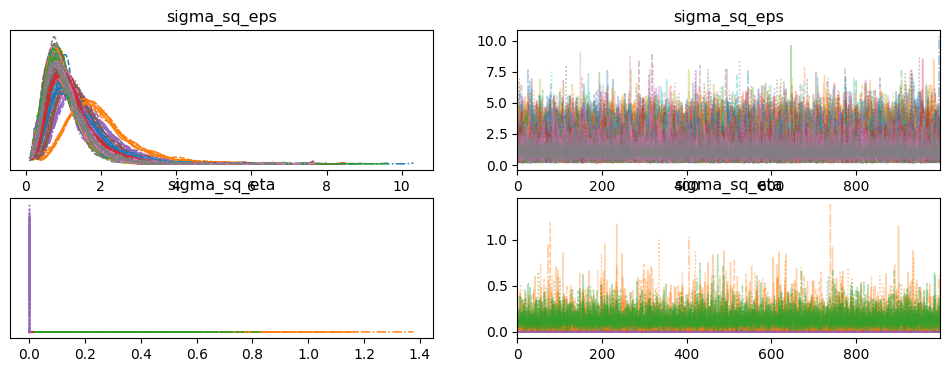

In [212]:
az.plot_trace(idata_2016_2, var_names=['sigma_sq_eps', 'sigma_sq_eta'])
plt.show()

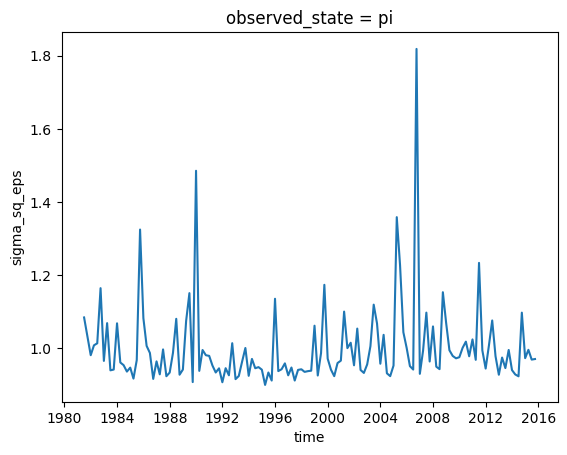

In [213]:
idata_2016_2.posterior['sigma_sq_eps'].median(['chain', 'draw']).plot()
plt.show()

In [214]:
cond_post_2016_2 = vkm_2016_2.sample_conditional_posterior(idata_2016_2)

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F00DCD057E0>), RNG(<Generator(PCG64) at 0x7F00DCD05E00>), RNG(<Generator(PCG64) at 0x7F00DCD06500>), RNG(<Generator(PCG64) at 0x7F00DCD06880>), RNG(<Generator(PCG64) at 0x7F00DCD05C40>), RNG(<Generator(PCG64) at 0x7F02584E6180>)] will not be used in the compiled JAX graph. Instead a copy will be used.
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

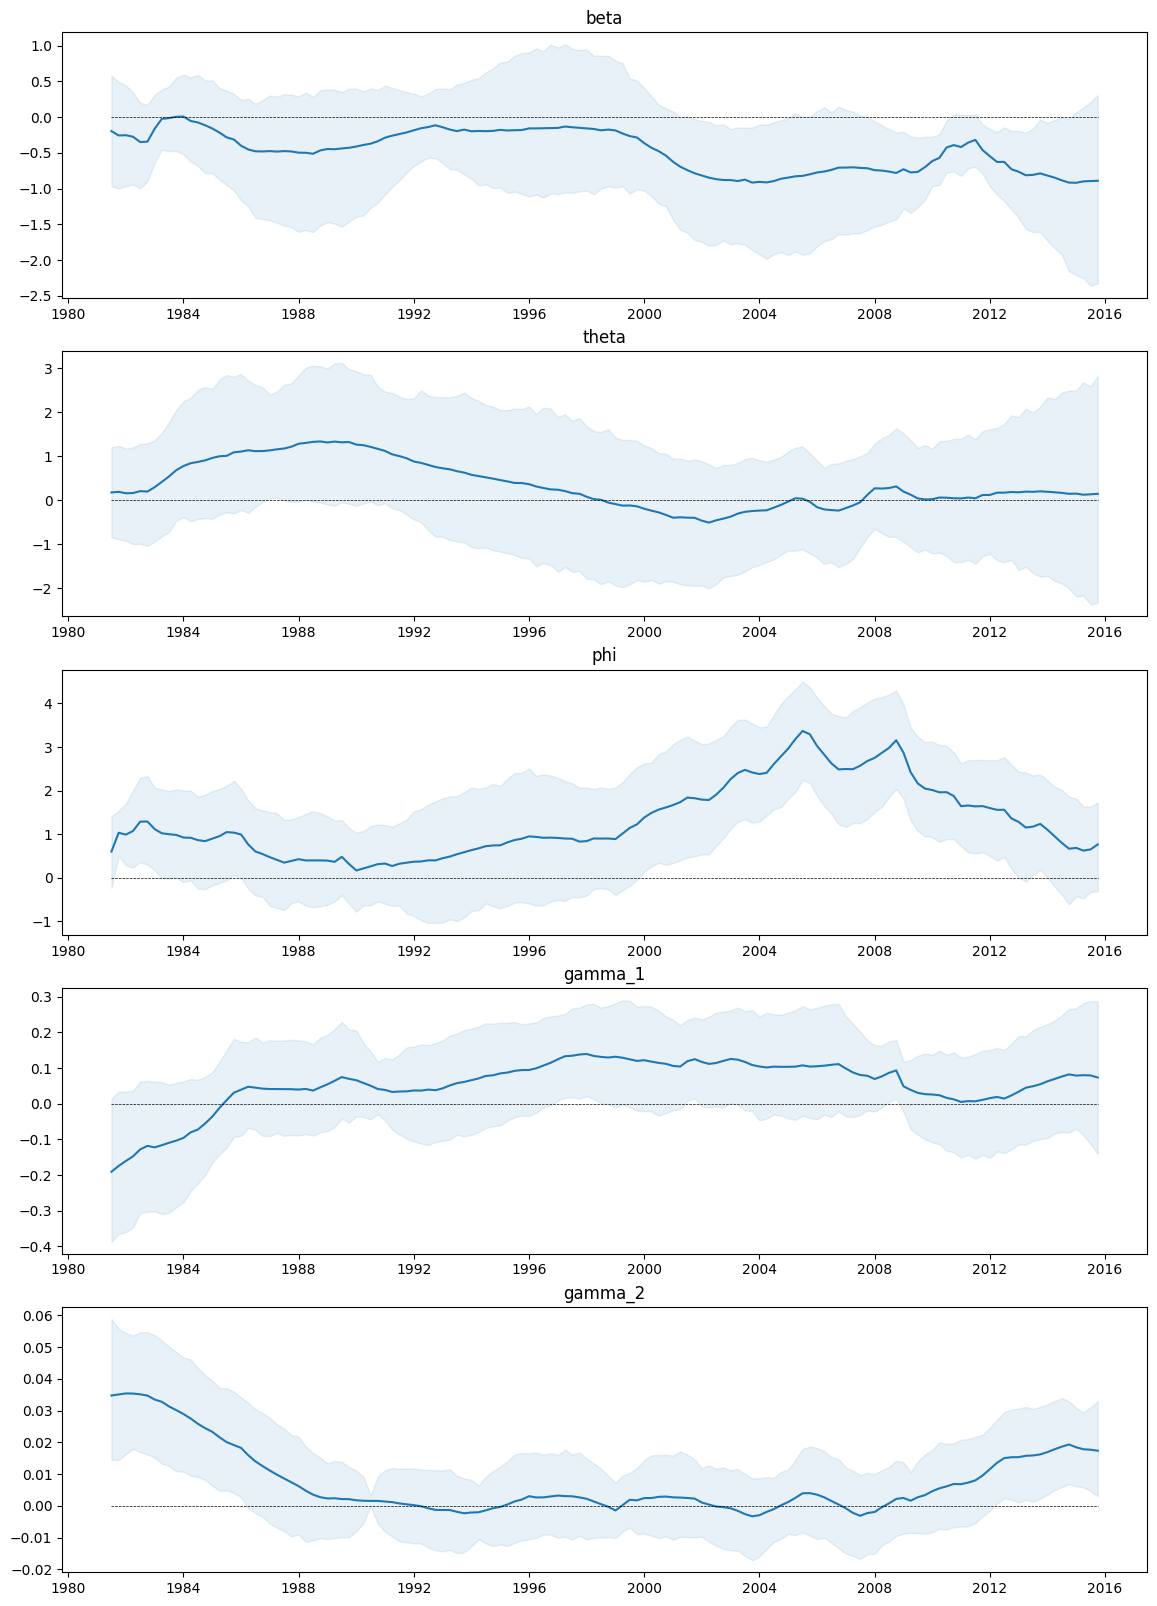

In [215]:
plot_latent_states(cond_post_2016_2)

#### 1981-2025

In [216]:
vkm_2, idata_2 = model_2(model_2025_df)

                                Model Requirements                                
                                                                                  
  Variable       Shape       Constraints                              Dimensions  
 ──────────────────────────────────────────────────────────────────────────────── 
  x0             (5,)        None                                     ('state',)  
  P0             (5, 5)      Positive Semi-definite       ('state', 'state_aux')  
  h              (None, 1)   Time-varying             ('time', 'observed_state')  
  sigma_sq_eta   (5,)        Positive                                 ('shock',)  
                                                                                  
  exog_data      (None, 5)   pm.Data                   ('time', 'exog_data_dim')  
                                                                                  
   These parameters should be assigned priors inside a PyMC model block before    
                    calling the build_statespace_graph method.                    

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [217]:
az.summary(idata_2, var_names=['sigma_sq_eps', 'sigma_sq_eta'])

mean     sd  hdi_3%  \
sigma_sq_eps[1981-07-01T00:00:00.000000000, pi]  1.200  0.671   0.285   
sigma_sq_eps[1981-10-01T00:00:00.000000000, pi]  1.164  0.629   0.283   
sigma_sq_eps[1982-01-01T00:00:00.000000000, pi]  1.101  0.563   0.275   
sigma_sq_eps[1982-04-01T00:00:00.000000000, pi]  1.156  0.612   0.267   
sigma_sq_eps[1982-07-01T00:00:00.000000000, pi]  1.154  0.600   0.242   
...                                                ...    ...     ...   
sigma_sq_eta[beta_shock]                         0.030  0.029   0.000   
sigma_sq_eta[theta_shock]                        0.082  0.095   0.000   
sigma_sq_eta[phi_shock]                          0.108  0.072   0.011   
sigma_sq_eta[gamma_1_shock]                      0.003  0.002   0.000   
sigma_sq_eta[gamma_2_shock]                      0.000  0.000   0.000   

                                                 hdi_97%  mcse_mean  mcse_sd  \
sigma_sq_eps[1981-07-01T00:00:00.000000000, pi]    2.448      0.006    0.007   
sigma_sq_eps[1981-10-01T00:00:00.000000000, pi]    2.284      0.006    0.006   
sigma_sq_eps[1982-01-01T00:00:00.000000000, pi]    2.106      0.005    0.005   
sigma_sq_eps[1982-04-01T00:00:00.000000000, pi]    2.247      0.006    0.005   
sigma_sq_eps[1982-07-01T00:00:00.000000000, pi]    2.178      0.005    0.005   
...                                                  ...        ...      ...   
sigma_sq_eta[beta_shock]                           0.081      0.000    0.000   
sigma_sq_eta[theta_shock]                          0.240      0.001    0.001   
sigma_sq_eta[phi_shock]                            0.237      0.001    0.001   
sigma_sq_eta[gamma_1_shock]                        0.006      0.000    0.000   
sigma_sq_eta[gamma_2_shock]                        0.000      0.000    0.000   

                                                 ess_bulk  ess_tail  r_hat  
sigma_sq_eps[1981-07-01T00:00:00.000000000, pi]   20626.0    4813.0    1.0  
sigma_sq_eps[1981-10-01T00:00:00.000000000, pi]   18418.0    5218.0    1.0  
sigma_sq_eps[1982-01-01T00:00:00.000000000, pi]   20366.0    5269.0    1.0  
sigma_sq_eps[1982-04-01T00:00:00.000000000, pi]   20811.0    6052.0    1.0  
sigma_sq_eps[1982-07-01T00:00:00.000000000, pi]   20875.0    5399.0    1.0  
...                                                   ...       ...    ...  
sigma_sq_eta[beta_shock]                           9375.0    5338.0    1.0  
sigma_sq_eta[theta_shock]                         10797.0    5026.0    1.0  
sigma_sq_eta[phi_shock]                           14031.0    6866.0    1.0  
sigma_sq_eta[gamma_1_shock]                       13674.0    6084.0    1.0  
sigma_sq_eta[gamma_2_shock]                       16086.0    5815.0    1.0  

[178 rows x 9 columns]

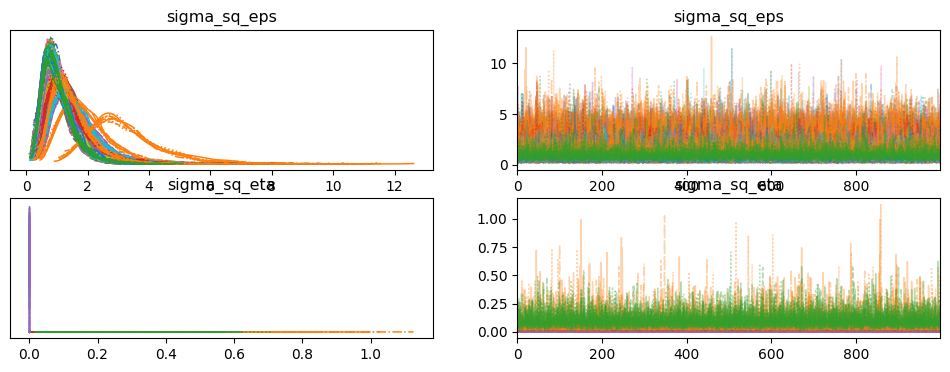

In [218]:
az.plot_trace(idata_2, var_names=['sigma_sq_eps', 'sigma_sq_eta'])
plt.show()

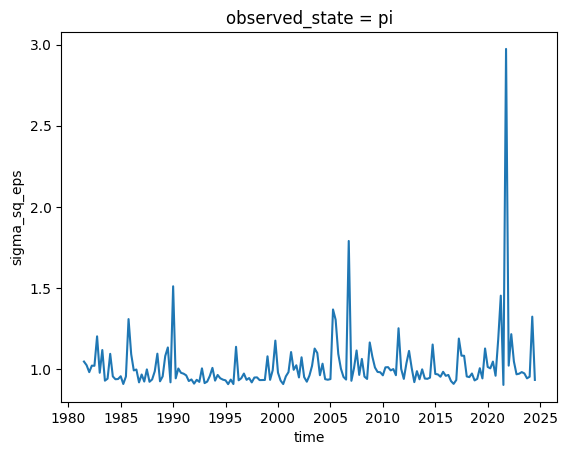

In [219]:
idata_2.posterior['sigma_sq_eps'].median(['chain', 'draw']).plot()
plt.show()

In [220]:
cond_post_2 = vkm_2.sample_conditional_posterior(idata_2)

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F00C34C5FC0>), RNG(<Generator(PCG64) at 0x7F00C34C6DC0>), RNG(<Generator(PCG64) at 0x7F00C34C7840>), RNG(<Generator(PCG64) at 0x7F00C34C7680>), RNG(<Generator(PCG64) at 0x7F00C34C6B20>), RNG(<Generator(PCG64) at 0x7F00C4B1B3E0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

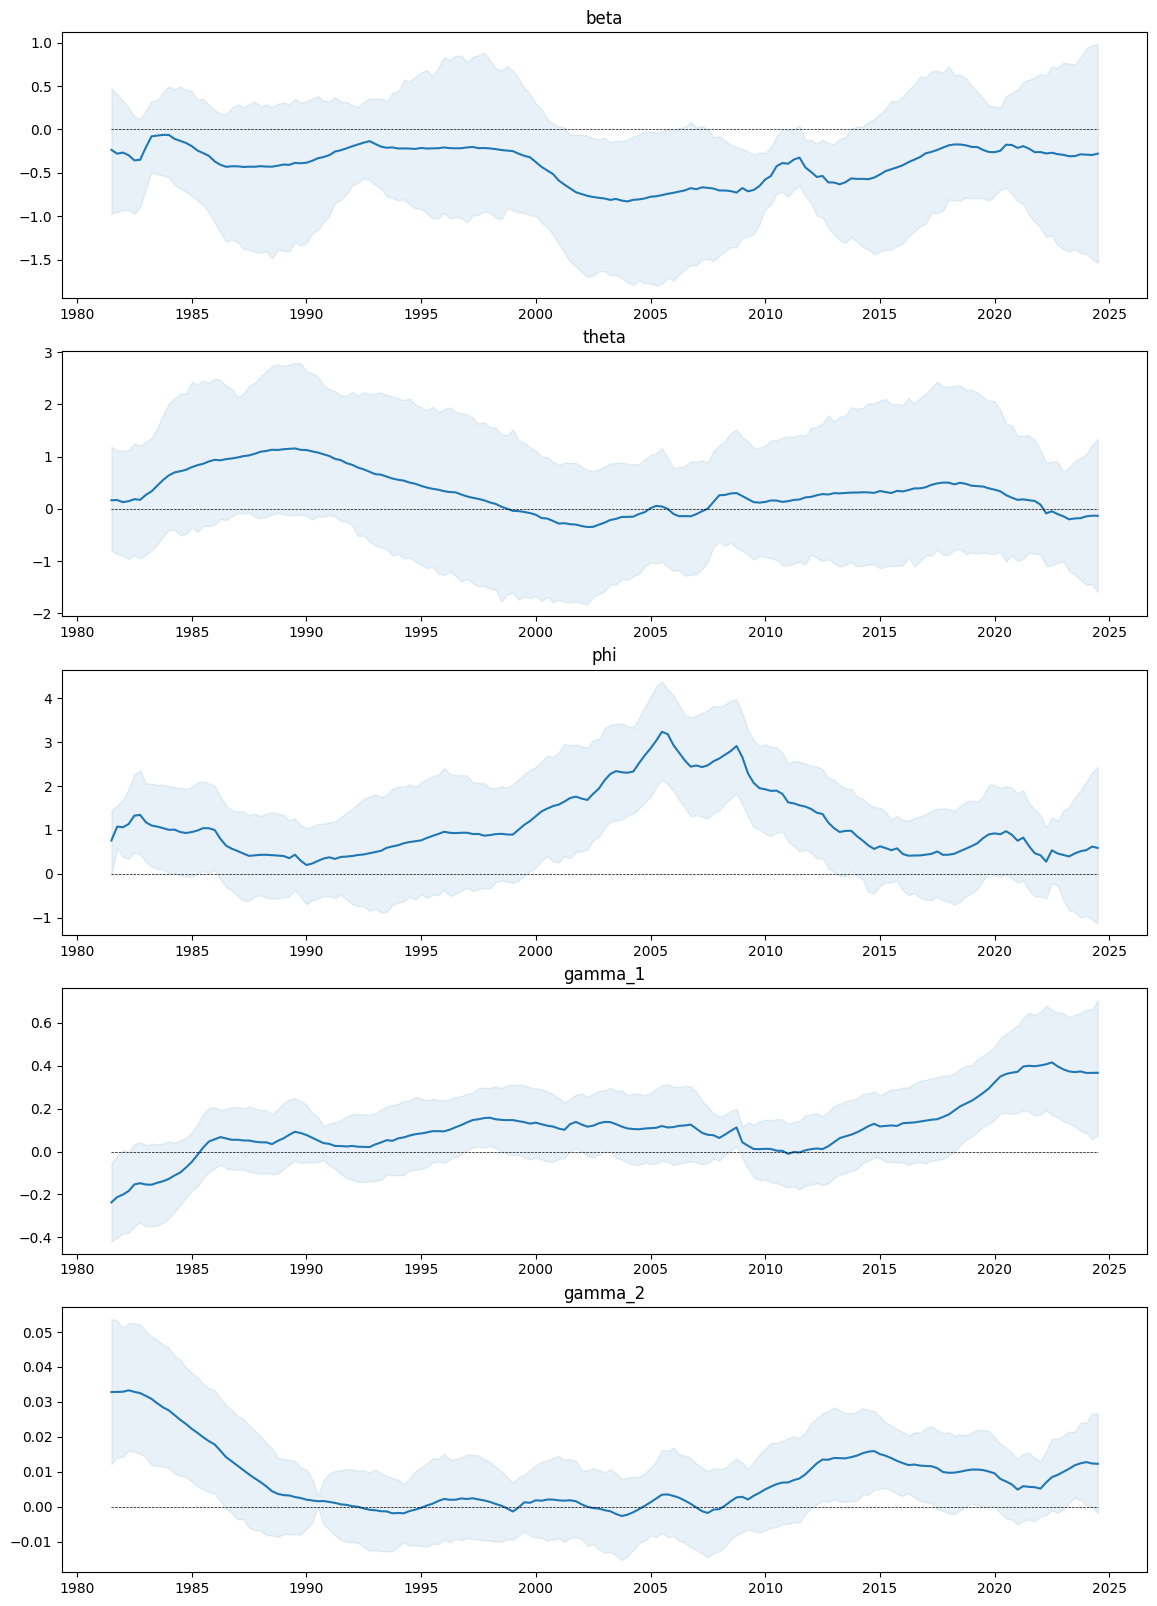

In [221]:
plot_latent_states(cond_post_2)

### Figure 4.3 a

#### Stricter priors

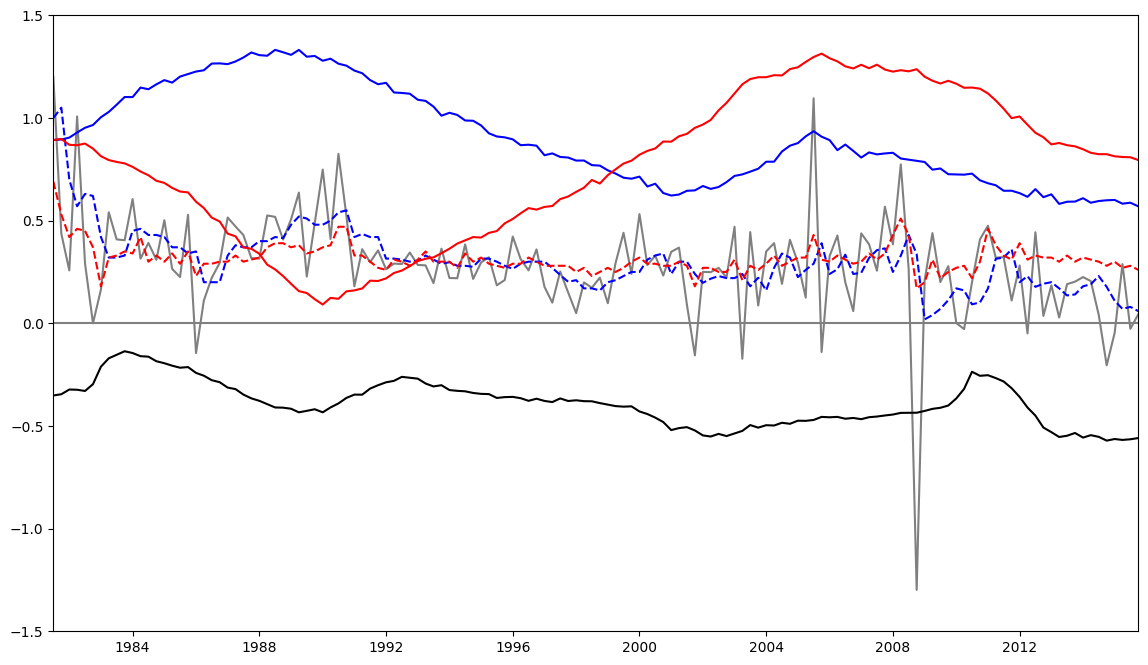

In [222]:
figure_4_3_a(model_2016_df, cond_post_2016)

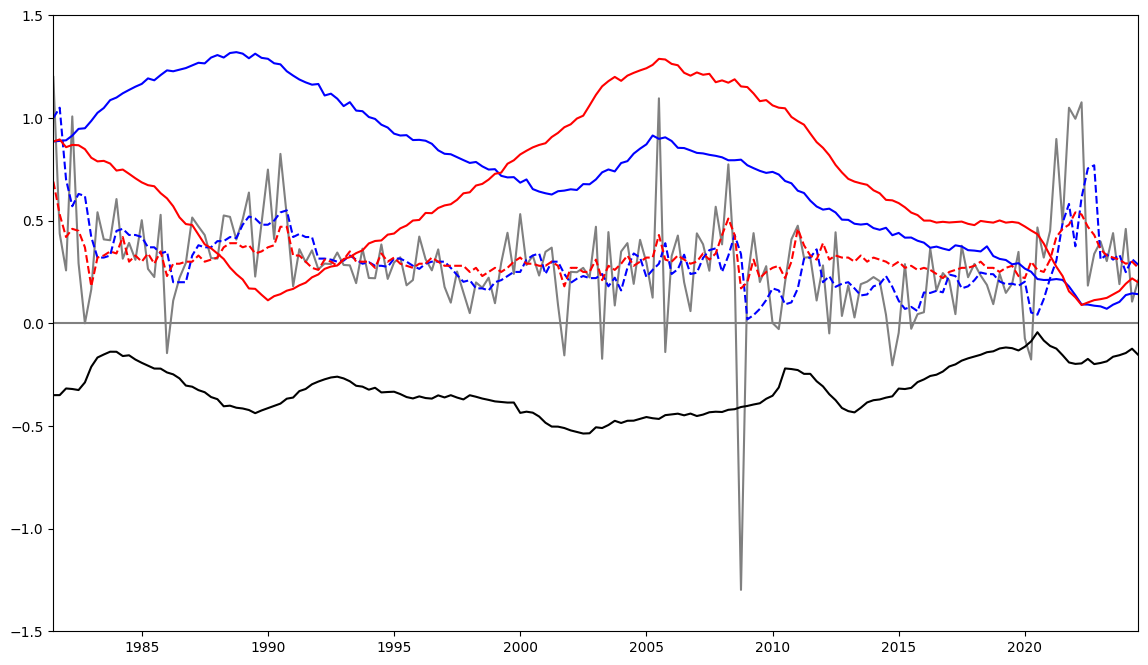

In [223]:
figure_4_3_a(model_2025_df, cond_post)

#### Weakly informative priors

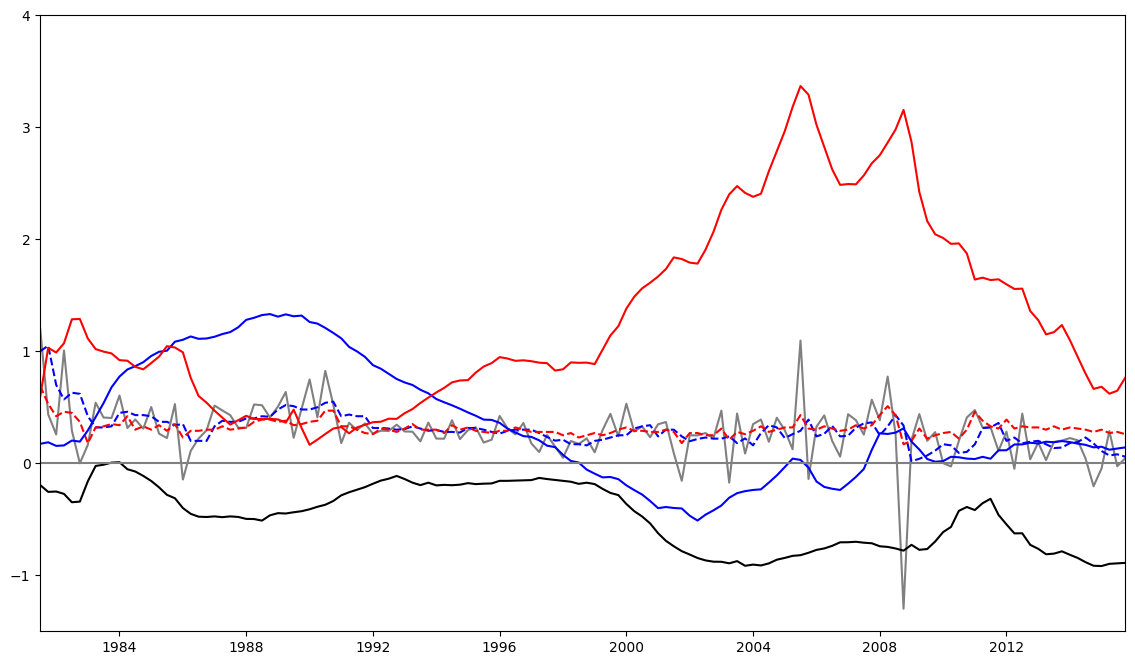

In [224]:
figure_4_3_a(model_2016_df, cond_post_2016_2, ylim=(-1.5, 4.0))

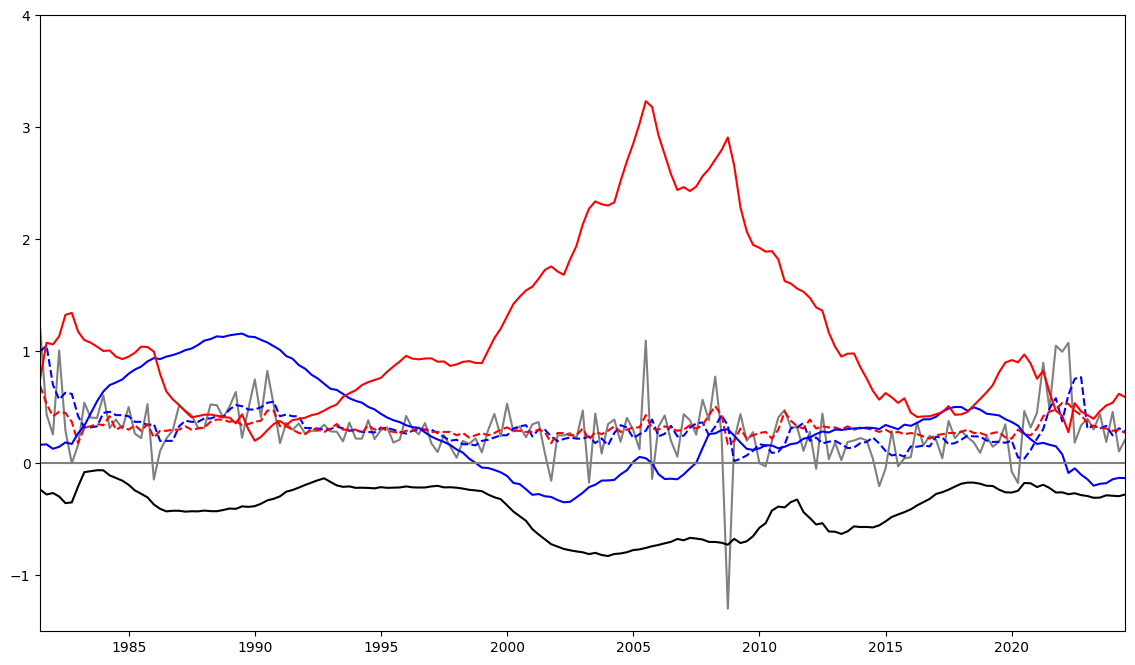

In [225]:
figure_4_3_a(model_2025_df, cond_post_2, ylim=(-1.5, 4.0))